# AAI Mini Project - Self-driving Jet Racer

## Project setup


In [1]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow import keras
import matplotlib as mpl
import random
import PIL
from sklearn.model_selection import train_test_split
from sklearn import metrics

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

dataset_dir = 'Dataset'
dataset_dir = os.path.join(os.getcwd(), dataset_dir)
print(dataset_dir)

/Users/lucavanstraaten/Documents/hhs/minor/Applied Artificial Intelligence/lab/project/Dataset


## Collecting images

please see a few random images from the dataset with the labels

the images are stored in the folder `Dataset` and the labels are the filename of the images


In [2]:
# Load the dataset, the folder contains all the images and the filename is the labels comma separated: "steering angle, throttle, image number.png"
# ignore all non png files

# create a list of all the files in the dataset folder
Dataset = []

for file in os.listdir(dataset_dir):
    if file.endswith(".png"):
        # add the file to the list
        Dataset.append(file)

# create a dataframe with the dataset
df = pd.DataFrame(Dataset, columns=['filename'])

# split the filename into 3 columns: steering angle, throttle, image number. but also keep the original filename
df[['steering_angle', 'throttle', 'image_number']] = df.filename.str.split(",",expand=True,)
df['image_number'] = df['image_number'].str.replace('.png', '')

# convert the columns to float
df['steering_angle'] = df['steering_angle'].astype(float)
df['throttle'] = df['throttle'].astype(float)

# convert image number to int
df['image_number'] = df['image_number'].astype(int)

# remove the filename column
# df = df.drop(['filename'], axis=1)

# sort the dataframe by image number
df = df.sort_values(by=['image_number'])

# reset the index
df = df.reset_index(drop=True)

# print the first 5 rows
df.head()


/var/folders/gd/_tzcwhnj41j_nysfjnpl80sc0000gn/T/ipykernel_75878/4250320461.py:17: FutureWarning: The default value of regex will change from True to False in a future version.
  df['image_number'] = df['image_number'].str.replace('.png', '')


,filename,steering_angle,throttle,image_number
0,"0.64,0.0,0.png",0.64,0.00,0
1,"0.1,-0.72,1.png",0.10,-0.72,1
2,"-0.02,-0.41,2.png",-0.02,-0.41,2
3,"0.24,-0.24,3.png",0.24,-0.24,3
4,"0.52,-0.63,4.png",0.52,-0.63,4


## Preprocessing the images


In [3]:
def preprocess(image):
    assert image.shape == (224,224,3)
    # crop the top 80 pixels
    image = image[80:,:,:]
    # convert to grayscale
    # image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # resize to 64x64
    image = cv2.resize(image, (64, 64))
    # Scale the images to the range of [0, 1]
    image = image / 255.0
    return image

## Creating the dataset

In [4]:
# now save the images in a np.array data and the labels in a np.array data_labels
# data_labels = [steering_angle, throttle]
data = []
data_labels = []

for _, row in df.iterrows():
    # read the image and put it through the preprocessing function
    image = preprocess(cv2.imread(os.path.join(dataset_dir, row['filename'])))
    # add the image to the data array
    data.append(image)
    # add the labels to the data_labels array
    data_labels.append([row['steering_angle'], row['throttle']])

# convert the data and data_labels to np.array
data = np.array(data)
data_labels = np.array(data_labels)

# print the shape of the data and data_labels
print(data.shape)
print(data_labels.shape)

(492, 64, 64, 3)
(492, 2)


## Data augmentation


In [5]:
# we note that we can easily create more data by flipping the images and changing the steering angle sign

# create a new array with the flipped images
data_flipped = np.flip(data, axis=2)

# create a new array with the flipped labels
data_labels_flipped = np.copy(data_labels)
data_labels_flipped[:,0] = -data_labels_flipped[:,0]

# now we can add the flipped images to the data and data_labels
data = np.concatenate((data, data_flipped), axis=0)
data_labels = np.concatenate((data_labels, data_labels_flipped), axis=0)

# print the shape of the data and data_labels
print(data.shape)
print(data_labels.shape)

(984, 64, 64, 3)
(984, 2)


In [6]:
# we flip the sign of the steering angle and the throttle so that left is negative and right is positive, and the throttle is negative when braking and positive when accelerating
# data_labels[:,0] = -data_labels[:,0]
data_labels[:,1] = -data_labels[:,1]

## Checkin the dataset

we have a little less than 1000 images in the dataset and we want to know the distribution of the labels


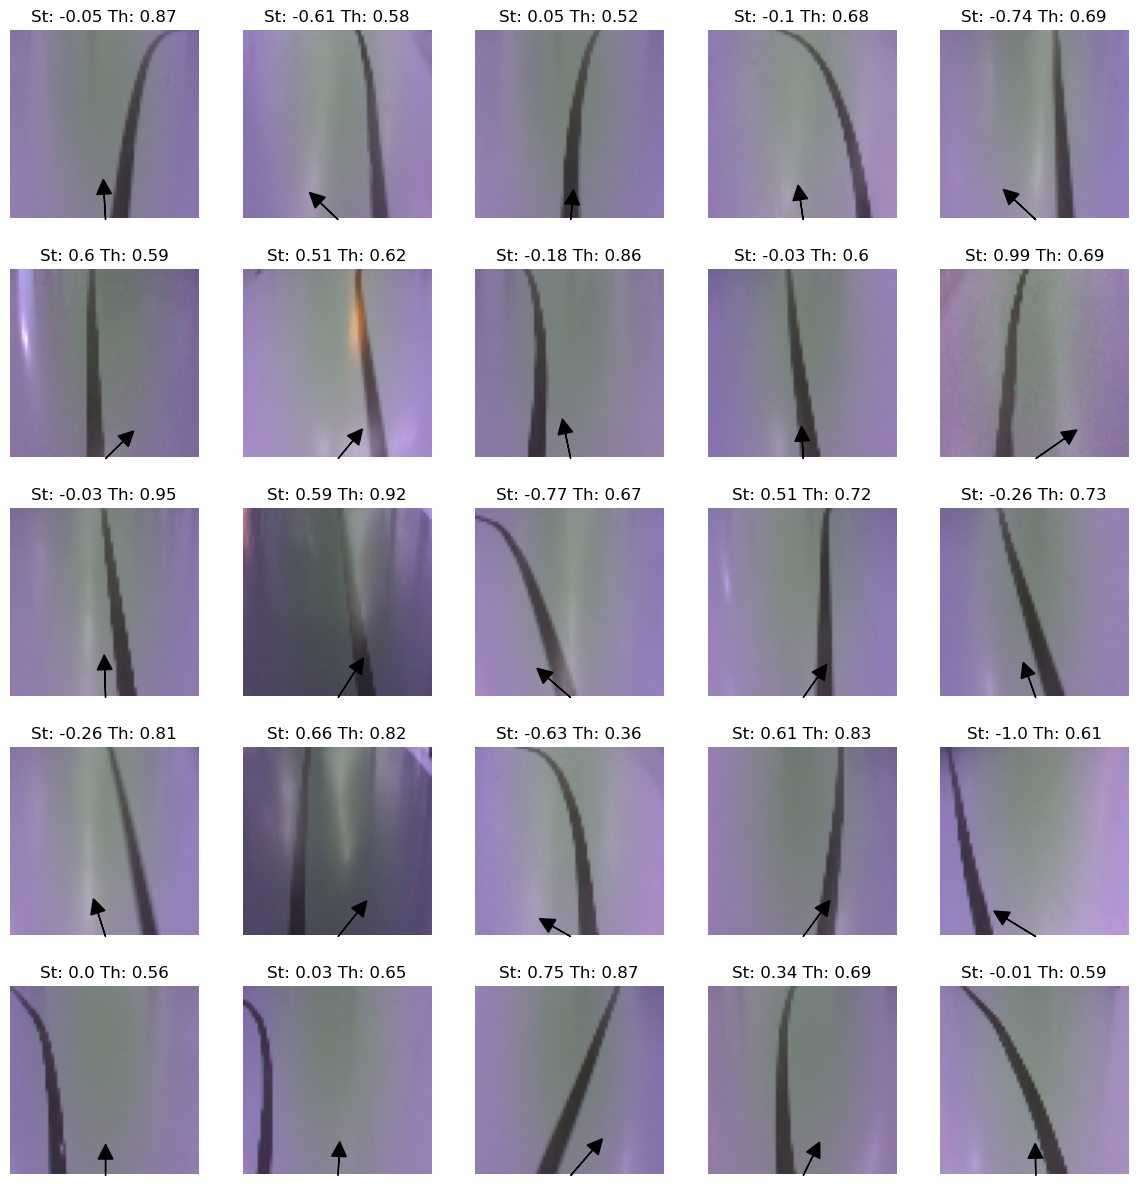

In [7]:
# plot 25 random images and their labels
fig, axs = plt.subplots(5, 5, figsize=(15, 15))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
for i in range(25):
    index = random.randint(0, data.shape[0])
    axs[i].imshow(data[index], cmap='gray')
    axs[i].set_title("St: " + str(data_labels[index][0]) + " Th: " + str(data_labels[index][1]))
    # plot the image, the steering angle and throttle and the real steering angle and throttle
    # also draw a arrow with the steering angle and throttle
    # the arrow will be baced on the middle bottom of the image and will point up for throttle and left or right for steering angle
    # the length of the arrow will be the throttle and the angle of the arrow will be the steering angle
    # make arrow position relative to the image size
    arrow_x = data[index].shape[0]/2
    arrow_y = data[index].shape[1]
    axs[i].arrow(arrow_x, arrow_y, data_labels[index][0]*10, -data_labels[index][1]*10, head_width=5, head_length=5, fc='k', ec='k')
    axs[i].axis('off')

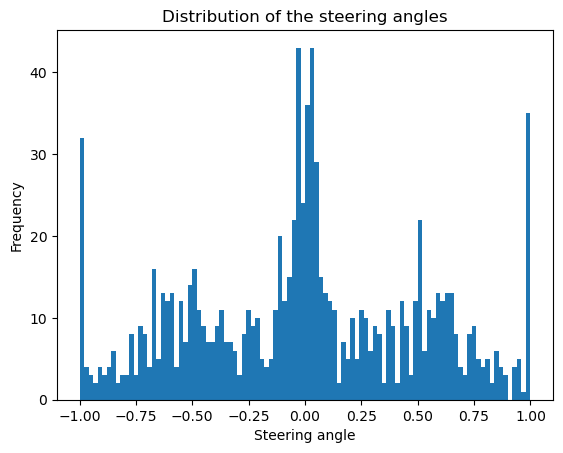

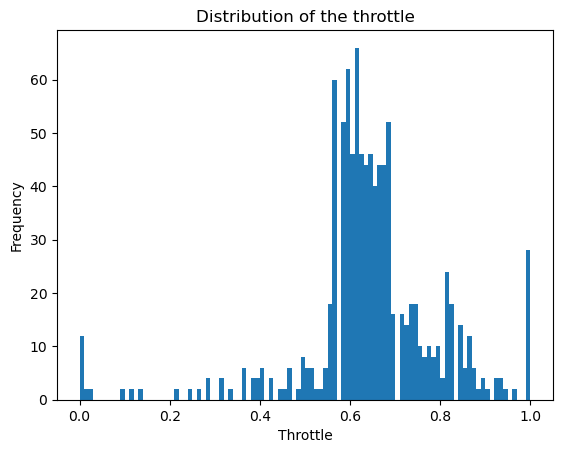

In [8]:
# plot the distribution of the steering angles
plt.hist(data_labels[:,0], bins=100)
plt.title("Distribution of the steering angles")
plt.xlabel("Steering angle")
plt.ylabel("Frequency")
plt.show()

# plot the distribution of the throttle
plt.hist(data_labels[:,1], bins=100)
plt.title("Distribution of the throttle")
plt.xlabel("Throttle")
plt.ylabel("Frequency")
plt.show()

# Splitting the dataset

We want to split the dataset into test and train dataset
We will use 80% of the dataset for training and 20% for testing

We then split the train into training and validation dataset


In [9]:
# split the data into test and train and validation
X_train, X_test, y_train, y_test = train_test_split(data, data_labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# print the shape of the data and data_labels
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(629, 64, 64, 3)
(629, 2)
(158, 64, 64, 3)
(158, 2)
(197, 64, 64, 3)
(197, 2)


## Making the model

we will use a simple CNN model to train the dataset


In [10]:
image_shape = X_train[0].shape

print(image_shape)

# make CNN the model
model = keras.models.Sequential()
# add the first convolutional layer
model.add(keras.layers.Conv2D(filters=256, kernel_size=7, strides=2, padding="same", activation="relu", input_shape=(image_shape[0], image_shape[1], image_shape[2])))
# add the first dropout layer
model.add(keras.layers.Dropout(0.2))
# add the second convolutional layer
model.add(keras.layers.Conv2D(filters=128, kernel_size=3, strides=2, padding="same", activation="relu"))
# add the second dropout layer
model.add(keras.layers.Dropout(0.2))
# add a layer downsample the image
model.add(keras.layers.AveragePooling2D(pool_size=3, strides=2, padding="same"))
# add the third convolutional layer
model.add(keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, padding="same", activation="relu"))
# reshape the data to 1D
model.add(keras.layers.Flatten())
# add the third dropout layer
model.add(keras.layers.Dropout(0.2))
# add the first dense layer
model.add(keras.layers.Dense(128, activation="relu"))
# add the fourth dropout layer
model.add(keras.layers.Dropout(0.2))
# add a BatchNormalization layer
model.add(keras.layers.BatchNormalization())
# add the second dense layer
model.add(keras.layers.Dense(64, activation="relu"))
# add the fifth dropout layer
model.add(keras.layers.Dropout(0.2))
# add a BatchNormalization layer
model.add(keras.layers.BatchNormalization())
# add the output layer
model.add(keras.layers.Dense(2, activation="tanh"))

# compile the model
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

# print the model summary
model.summary()


(64, 64, 3)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 256)       37888     
                                                                 
 dropout (Dropout)           (None, 32, 32, 256)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       295040    
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 128)       0         
                                                                 
 average_pooling2d (AverageP  (None, 8, 8, 128)        0         
 ooling2D)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          73792     
                                            

2022-12-18 01:21:18.194315: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Training the model

In [11]:
# Training the model, and after every epoch we update the history and plot the training and validation loss and accuracy, we also set the dropout rate to 0.5
history = model.fit(X_train, y_train, epochs=5000, batch_size=32, validation_data=(X_val, y_val), verbose=1, shuffle=True)

Epoch 1/5000
20/20 [==============================] - 4s 184ms/step - loss: 0.8366 - mae: 0.7405 - val_loss: 2.0080 - val_mae: 1.3346
Epoch 2/5000
20/20 [==============================] - 4s 192ms/step - loss: 0.7177 - mae: 0.6861 - val_loss: 1.9662 - val_mae: 1.3148
Epoch 3/5000
20/20 [==============================] - 4s 183ms/step - loss: 0.6355 - mae: 0.6309 - val_loss: 1.7636 - val_mae: 1.2357
Epoch 4/5000
20/20 [==============================] - 4s 181ms/step - loss: 0.5620 - mae: 0.5884 - val_loss: 1.0505 - val_mae: 0.9421
Epoch 5/5000
20/20 [==============================] - 4s 198ms/step - loss: 0.4904 - mae: 0.5434 - val_loss: 0.6769 - val_mae: 0.7338
Epoch 6/5000
20/20 [==============================] - 4s 204ms/step - loss: 0.4189 - mae: 0.4957 - val_loss: 0.2512 - val_mae: 0.4059
Epoch 7/5000
20/20 [==============================] - 4s 197ms/step - loss: 0.3799 - mae: 0.4656 - val_loss: 0.1525 - val_mae: 0.2817
Epoch 8/5000
20/20 [==============================] - 4s 183ms

Epoch 62/5000
20/20 [==============================] - 3s 174ms/step - loss: 0.1550 - mae: 0.2784 - val_loss: 0.1387 - val_mae: 0.2532
Epoch 63/5000
20/20 [==============================] - 3s 173ms/step - loss: 0.1526 - mae: 0.2757 - val_loss: 0.1388 - val_mae: 0.2537
Epoch 64/5000
20/20 [==============================] - 4s 177ms/step - loss: 0.1519 - mae: 0.2739 - val_loss: 0.1402 - val_mae: 0.2554
Epoch 65/5000
20/20 [==============================] - 3s 173ms/step - loss: 0.1555 - mae: 0.2777 - val_loss: 0.1394 - val_mae: 0.2561
Epoch 66/5000
20/20 [==============================] - 4s 176ms/step - loss: 0.1553 - mae: 0.2776 - val_loss: 0.1385 - val_mae: 0.2539
Epoch 67/5000
20/20 [==============================] - 3s 171ms/step - loss: 0.1538 - mae: 0.2763 - val_loss: 0.1380 - val_mae: 0.2534
Epoch 68/5000
20/20 [==============================] - 4s 180ms/step - loss: 0.1542 - mae: 0.2772 - val_loss: 0.1380 - val_mae: 0.2538
Epoch 69/5000
20/20 [==============================] - 

20/20 [==============================] - 4s 203ms/step - loss: 0.1468 - mae: 0.2621 - val_loss: 0.1609 - val_mae: 0.3284
Epoch 123/5000
20/20 [==============================] - 4s 224ms/step - loss: 0.1501 - mae: 0.2639 - val_loss: 0.1516 - val_mae: 0.2690
Epoch 124/5000
20/20 [==============================] - 4s 198ms/step - loss: 0.1479 - mae: 0.2636 - val_loss: 0.1324 - val_mae: 0.2535
Epoch 125/5000
20/20 [==============================] - 4s 181ms/step - loss: 0.1437 - mae: 0.2605 - val_loss: 0.1340 - val_mae: 0.2513
Epoch 126/5000
20/20 [==============================] - 4s 183ms/step - loss: 0.1474 - mae: 0.2615 - val_loss: 0.1306 - val_mae: 0.2470
Epoch 127/5000
20/20 [==============================] - 3s 174ms/step - loss: 0.1414 - mae: 0.2579 - val_loss: 0.1320 - val_mae: 0.2513
Epoch 128/5000
20/20 [==============================] - 4s 175ms/step - loss: 0.1403 - mae: 0.2563 - val_loss: 0.1251 - val_mae: 0.2428
Epoch 129/5000
20/20 [==============================] - 4s 182m

20/20 [==============================] - 3s 173ms/step - loss: 0.1496 - mae: 0.2617 - val_loss: 0.1362 - val_mae: 0.2514
Epoch 183/5000
20/20 [==============================] - 4s 175ms/step - loss: 0.1512 - mae: 0.2629 - val_loss: 0.1373 - val_mae: 0.2558
Epoch 184/5000
20/20 [==============================] - 3s 172ms/step - loss: 0.1503 - mae: 0.2626 - val_loss: 0.1391 - val_mae: 0.2631
Epoch 185/5000
20/20 [==============================] - 3s 172ms/step - loss: 0.1473 - mae: 0.2598 - val_loss: 0.1399 - val_mae: 0.2638
Epoch 186/5000
20/20 [==============================] - 4s 178ms/step - loss: 0.1514 - mae: 0.2640 - val_loss: 0.1379 - val_mae: 0.2555
Epoch 187/5000
20/20 [==============================] - 3s 172ms/step - loss: 0.1486 - mae: 0.2609 - val_loss: 0.1412 - val_mae: 0.2566
Epoch 188/5000
20/20 [==============================] - 4s 176ms/step - loss: 0.1503 - mae: 0.2624 - val_loss: 0.1374 - val_mae: 0.2519
Epoch 189/5000
20/20 [==============================] - 5s 232m

20/20 [==============================] - 4s 175ms/step - loss: 0.1485 - mae: 0.2600 - val_loss: 0.1396 - val_mae: 0.2768
Epoch 243/5000
20/20 [==============================] - 3s 175ms/step - loss: 0.1462 - mae: 0.2578 - val_loss: 0.1376 - val_mae: 0.2614
Epoch 244/5000
20/20 [==============================] - 3s 172ms/step - loss: 0.1488 - mae: 0.2607 - val_loss: 0.1375 - val_mae: 0.2593
Epoch 245/5000
20/20 [==============================] - 3s 175ms/step - loss: 0.1502 - mae: 0.2629 - val_loss: 0.1352 - val_mae: 0.2528
Epoch 246/5000
20/20 [==============================] - 4s 183ms/step - loss: 0.1490 - mae: 0.2607 - val_loss: 0.1368 - val_mae: 0.2553
Epoch 247/5000
20/20 [==============================] - 3s 170ms/step - loss: 0.1494 - mae: 0.2611 - val_loss: 0.1443 - val_mae: 0.2588
Epoch 248/5000
20/20 [==============================] - 4s 177ms/step - loss: 0.1493 - mae: 0.2610 - val_loss: 0.1363 - val_mae: 0.2522
Epoch 249/5000
20/20 [==============================] - 3s 174m

20/20 [==============================] - 3s 174ms/step - loss: 0.1479 - mae: 0.2593 - val_loss: 0.1410 - val_mae: 0.2556
Epoch 303/5000
20/20 [==============================] - 3s 171ms/step - loss: 0.1505 - mae: 0.2610 - val_loss: 0.1406 - val_mae: 0.2556
Epoch 304/5000
20/20 [==============================] - 4s 177ms/step - loss: 0.1501 - mae: 0.2622 - val_loss: 0.1401 - val_mae: 0.2546
Epoch 305/5000
20/20 [==============================] - 3s 172ms/step - loss: 0.1495 - mae: 0.2608 - val_loss: 0.1403 - val_mae: 0.2543
Epoch 306/5000
20/20 [==============================] - 3s 172ms/step - loss: 0.1485 - mae: 0.2611 - val_loss: 0.1417 - val_mae: 0.2558
Epoch 307/5000
20/20 [==============================] - 4s 176ms/step - loss: 0.1486 - mae: 0.2605 - val_loss: 0.1410 - val_mae: 0.2552
Epoch 308/5000
20/20 [==============================] - 3s 174ms/step - loss: 0.1492 - mae: 0.2618 - val_loss: 0.1394 - val_mae: 0.2543
Epoch 309/5000
20/20 [==============================] - 3s 172m

20/20 [==============================] - 3s 173ms/step - loss: 0.1462 - mae: 0.2600 - val_loss: 0.1286 - val_mae: 0.2452
Epoch 363/5000
20/20 [==============================] - 3s 173ms/step - loss: 0.1439 - mae: 0.2564 - val_loss: 0.1353 - val_mae: 0.2510
Epoch 364/5000
20/20 [==============================] - 3s 172ms/step - loss: 0.1407 - mae: 0.2534 - val_loss: 0.1254 - val_mae: 0.2438
Epoch 365/5000
20/20 [==============================] - 3s 173ms/step - loss: 0.1437 - mae: 0.2567 - val_loss: 0.2180 - val_mae: 0.3930
Epoch 366/5000
20/20 [==============================] - 4s 175ms/step - loss: 0.1475 - mae: 0.2621 - val_loss: 0.1319 - val_mae: 0.2558
Epoch 367/5000
20/20 [==============================] - 3s 174ms/step - loss: 0.1453 - mae: 0.2591 - val_loss: 0.1281 - val_mae: 0.2502
Epoch 368/5000
20/20 [==============================] - 3s 173ms/step - loss: 0.1435 - mae: 0.2561 - val_loss: 0.1300 - val_mae: 0.2501
Epoch 369/5000
20/20 [==============================] - 3s 171m

20/20 [==============================] - 4s 220ms/step - loss: 0.1447 - mae: 0.2600 - val_loss: 0.1332 - val_mae: 0.2630
Epoch 423/5000
20/20 [==============================] - 4s 197ms/step - loss: 0.1456 - mae: 0.2586 - val_loss: 0.1211 - val_mae: 0.2412
Epoch 424/5000
20/20 [==============================] - 4s 179ms/step - loss: 0.1382 - mae: 0.2531 - val_loss: 0.1289 - val_mae: 0.2550
Epoch 425/5000
20/20 [==============================] - 4s 185ms/step - loss: 0.1395 - mae: 0.2535 - val_loss: 0.1134 - val_mae: 0.2374
Epoch 426/5000
20/20 [==============================] - 3s 171ms/step - loss: 0.1386 - mae: 0.2529 - val_loss: 0.1925 - val_mae: 0.3014
Epoch 427/5000
20/20 [==============================] - 4s 176ms/step - loss: 0.1361 - mae: 0.2494 - val_loss: 0.1061 - val_mae: 0.2291
Epoch 428/5000
20/20 [==============================] - 4s 179ms/step - loss: 0.1360 - mae: 0.2504 - val_loss: 0.1071 - val_mae: 0.2289
Epoch 429/5000
20/20 [==============================] - 4s 175m

20/20 [==============================] - 3s 174ms/step - loss: 0.1202 - mae: 0.2395 - val_loss: 0.1260 - val_mae: 0.2469
Epoch 483/5000
20/20 [==============================] - 3s 174ms/step - loss: 0.1207 - mae: 0.2396 - val_loss: 0.1165 - val_mae: 0.2396
Epoch 484/5000
20/20 [==============================] - 4s 176ms/step - loss: 0.1236 - mae: 0.2420 - val_loss: 0.1270 - val_mae: 0.2776
Epoch 485/5000
20/20 [==============================] - 3s 171ms/step - loss: 0.1200 - mae: 0.2399 - val_loss: 0.1075 - val_mae: 0.2320
Epoch 486/5000
20/20 [==============================] - 4s 176ms/step - loss: 0.1165 - mae: 0.2371 - val_loss: 0.1090 - val_mae: 0.2323
Epoch 487/5000
20/20 [==============================] - 3s 174ms/step - loss: 0.1116 - mae: 0.2326 - val_loss: 0.1085 - val_mae: 0.2302
Epoch 488/5000
20/20 [==============================] - 4s 214ms/step - loss: 0.1093 - mae: 0.2301 - val_loss: 0.1074 - val_mae: 0.2298
Epoch 489/5000
20/20 [==============================] - 5s 232m

20/20 [==============================] - 3s 173ms/step - loss: 0.0805 - mae: 0.2020 - val_loss: 0.1054 - val_mae: 0.2263
Epoch 543/5000
20/20 [==============================] - 4s 175ms/step - loss: 0.0774 - mae: 0.1978 - val_loss: 0.1070 - val_mae: 0.2254
Epoch 544/5000
20/20 [==============================] - 4s 178ms/step - loss: 0.0809 - mae: 0.1999 - val_loss: 0.1050 - val_mae: 0.2293
Epoch 545/5000
20/20 [==============================] - 4s 176ms/step - loss: 0.0791 - mae: 0.2015 - val_loss: 0.1095 - val_mae: 0.2304
Epoch 546/5000
20/20 [==============================] - 3s 174ms/step - loss: 0.0762 - mae: 0.1967 - val_loss: 0.1081 - val_mae: 0.2315
Epoch 547/5000
20/20 [==============================] - 3s 174ms/step - loss: 0.0802 - mae: 0.1994 - val_loss: 0.1052 - val_mae: 0.2271
Epoch 548/5000
20/20 [==============================] - 3s 172ms/step - loss: 0.0816 - mae: 0.2033 - val_loss: 0.1078 - val_mae: 0.2289
Epoch 549/5000
20/20 [==============================] - 3s 173m

20/20 [==============================] - 4s 176ms/step - loss: 0.0765 - mae: 0.1939 - val_loss: 0.1201 - val_mae: 0.2388
Epoch 603/5000
20/20 [==============================] - 3s 175ms/step - loss: 0.0729 - mae: 0.1927 - val_loss: 0.1131 - val_mae: 0.2376
Epoch 604/5000
20/20 [==============================] - 3s 175ms/step - loss: 0.0967 - mae: 0.2186 - val_loss: 0.1247 - val_mae: 0.2418
Epoch 605/5000
20/20 [==============================] - 4s 175ms/step - loss: 0.0884 - mae: 0.2081 - val_loss: 0.1143 - val_mae: 0.2334
Epoch 606/5000
20/20 [==============================] - 3s 172ms/step - loss: 0.0797 - mae: 0.1982 - val_loss: 0.1176 - val_mae: 0.2435
Epoch 607/5000
20/20 [==============================] - 3s 173ms/step - loss: 0.0702 - mae: 0.1860 - val_loss: 0.1308 - val_mae: 0.2532
Epoch 608/5000
20/20 [==============================] - 4s 175ms/step - loss: 0.0766 - mae: 0.1954 - val_loss: 0.1317 - val_mae: 0.2517
Epoch 609/5000
20/20 [==============================] - 3s 173m

20/20 [==============================] - 3s 163ms/step - loss: 0.0552 - mae: 0.1693 - val_loss: 0.1263 - val_mae: 0.2468
Epoch 663/5000
20/20 [==============================] - 3s 156ms/step - loss: 0.0505 - mae: 0.1613 - val_loss: 0.1277 - val_mae: 0.2458
Epoch 664/5000
20/20 [==============================] - 3s 171ms/step - loss: 0.0578 - mae: 0.1670 - val_loss: 0.1305 - val_mae: 0.2503
Epoch 665/5000
20/20 [==============================] - 3s 157ms/step - loss: 0.0519 - mae: 0.1614 - val_loss: 0.1367 - val_mae: 0.2536
Epoch 666/5000
20/20 [==============================] - 3s 156ms/step - loss: 0.0586 - mae: 0.1741 - val_loss: 0.1378 - val_mae: 0.2532
Epoch 667/5000
20/20 [==============================] - 3s 155ms/step - loss: 0.0539 - mae: 0.1652 - val_loss: 0.1387 - val_mae: 0.2540
Epoch 668/5000
20/20 [==============================] - 3s 161ms/step - loss: 0.0536 - mae: 0.1664 - val_loss: 0.1346 - val_mae: 0.2498
Epoch 669/5000
20/20 [==============================] - 3s 158m

20/20 [==============================] - 3s 158ms/step - loss: 0.0479 - mae: 0.1571 - val_loss: 0.1455 - val_mae: 0.2641
Epoch 723/5000
20/20 [==============================] - 3s 159ms/step - loss: 0.0469 - mae: 0.1559 - val_loss: 0.1388 - val_mae: 0.2625
Epoch 724/5000
20/20 [==============================] - 3s 156ms/step - loss: 0.0434 - mae: 0.1509 - val_loss: 0.1432 - val_mae: 0.2663
Epoch 725/5000
20/20 [==============================] - 3s 157ms/step - loss: 0.0437 - mae: 0.1494 - val_loss: 0.1416 - val_mae: 0.2634
Epoch 726/5000
20/20 [==============================] - 3s 154ms/step - loss: 0.0424 - mae: 0.1494 - val_loss: 0.1396 - val_mae: 0.2601
Epoch 727/5000
20/20 [==============================] - 3s 158ms/step - loss: 0.0481 - mae: 0.1549 - val_loss: 0.1344 - val_mae: 0.2546
Epoch 728/5000
20/20 [==============================] - 3s 161ms/step - loss: 0.0414 - mae: 0.1462 - val_loss: 0.1351 - val_mae: 0.2554
Epoch 729/5000
20/20 [==============================] - 3s 157m

20/20 [==============================] - 3s 155ms/step - loss: 0.0349 - mae: 0.1367 - val_loss: 0.1453 - val_mae: 0.2650
Epoch 783/5000
20/20 [==============================] - 3s 157ms/step - loss: 0.0400 - mae: 0.1441 - val_loss: 0.1455 - val_mae: 0.2630
Epoch 784/5000
20/20 [==============================] - 3s 158ms/step - loss: 0.0375 - mae: 0.1374 - val_loss: 0.1476 - val_mae: 0.2651
Epoch 785/5000
20/20 [==============================] - 3s 168ms/step - loss: 0.0350 - mae: 0.1338 - val_loss: 0.1547 - val_mae: 0.2717
Epoch 786/5000
20/20 [==============================] - 3s 159ms/step - loss: 0.0403 - mae: 0.1439 - val_loss: 0.1584 - val_mae: 0.2733
Epoch 787/5000
20/20 [==============================] - 3s 163ms/step - loss: 0.0346 - mae: 0.1347 - val_loss: 0.1585 - val_mae: 0.2747
Epoch 788/5000
20/20 [==============================] - 3s 157ms/step - loss: 0.0365 - mae: 0.1381 - val_loss: 0.1482 - val_mae: 0.2678
Epoch 789/5000
20/20 [==============================] - 3s 157m

20/20 [==============================] - 3s 173ms/step - loss: 0.0332 - mae: 0.1295 - val_loss: 0.1550 - val_mae: 0.2742
Epoch 843/5000
20/20 [==============================] - 3s 156ms/step - loss: 0.0294 - mae: 0.1281 - val_loss: 0.1521 - val_mae: 0.2704
Epoch 844/5000
20/20 [==============================] - 3s 158ms/step - loss: 0.0266 - mae: 0.1209 - val_loss: 0.1590 - val_mae: 0.2763
Epoch 845/5000
20/20 [==============================] - 3s 168ms/step - loss: 0.0315 - mae: 0.1296 - val_loss: 0.1597 - val_mae: 0.2769
Epoch 846/5000
20/20 [==============================] - 3s 157ms/step - loss: 0.0375 - mae: 0.1389 - val_loss: 0.1732 - val_mae: 0.2828
Epoch 847/5000
20/20 [==============================] - 3s 157ms/step - loss: 0.0353 - mae: 0.1343 - val_loss: 0.1579 - val_mae: 0.2721
Epoch 848/5000
20/20 [==============================] - 3s 159ms/step - loss: 0.0348 - mae: 0.1315 - val_loss: 0.1634 - val_mae: 0.2782
Epoch 849/5000
20/20 [==============================] - 3s 158m

20/20 [==============================] - 3s 154ms/step - loss: 0.0286 - mae: 0.1241 - val_loss: 0.1439 - val_mae: 0.2658
Epoch 903/5000
20/20 [==============================] - 3s 158ms/step - loss: 0.0270 - mae: 0.1188 - val_loss: 0.1596 - val_mae: 0.2781
Epoch 904/5000
20/20 [==============================] - 3s 156ms/step - loss: 0.0256 - mae: 0.1161 - val_loss: 0.1562 - val_mae: 0.2773
Epoch 905/5000
20/20 [==============================] - 3s 162ms/step - loss: 0.0250 - mae: 0.1164 - val_loss: 0.1571 - val_mae: 0.2774
Epoch 906/5000
20/20 [==============================] - 3s 157ms/step - loss: 0.0302 - mae: 0.1258 - val_loss: 0.1622 - val_mae: 0.2812
Epoch 907/5000
20/20 [==============================] - 3s 160ms/step - loss: 0.0274 - mae: 0.1214 - val_loss: 0.1495 - val_mae: 0.2718
Epoch 908/5000
20/20 [==============================] - 3s 156ms/step - loss: 0.0289 - mae: 0.1204 - val_loss: 0.1519 - val_mae: 0.2714
Epoch 909/5000
20/20 [==============================] - 3s 159m

20/20 [==============================] - 3s 154ms/step - loss: 0.0264 - mae: 0.1174 - val_loss: 0.1584 - val_mae: 0.2783
Epoch 963/5000
20/20 [==============================] - 3s 162ms/step - loss: 0.0266 - mae: 0.1175 - val_loss: 0.1518 - val_mae: 0.2733
Epoch 964/5000
20/20 [==============================] - 3s 154ms/step - loss: 0.0257 - mae: 0.1145 - val_loss: 0.1526 - val_mae: 0.2738
Epoch 965/5000
20/20 [==============================] - 3s 158ms/step - loss: 0.0255 - mae: 0.1121 - val_loss: 0.1505 - val_mae: 0.2726
Epoch 966/5000
20/20 [==============================] - 3s 154ms/step - loss: 0.0258 - mae: 0.1168 - val_loss: 0.1527 - val_mae: 0.2746
Epoch 967/5000
20/20 [==============================] - 3s 161ms/step - loss: 0.0259 - mae: 0.1165 - val_loss: 0.1496 - val_mae: 0.2731
Epoch 968/5000
20/20 [==============================] - 3s 156ms/step - loss: 0.0261 - mae: 0.1183 - val_loss: 0.1455 - val_mae: 0.2659
Epoch 969/5000
20/20 [==============================] - 3s 158m

20/20 [==============================] - 3s 155ms/step - loss: 0.0197 - mae: 0.1047 - val_loss: 0.1454 - val_mae: 0.2686
Epoch 1023/5000
20/20 [==============================] - 3s 157ms/step - loss: 0.0236 - mae: 0.1120 - val_loss: 0.1407 - val_mae: 0.2635
Epoch 1024/5000
20/20 [==============================] - 3s 157ms/step - loss: 0.0256 - mae: 0.1141 - val_loss: 0.1515 - val_mae: 0.2734
Epoch 1025/5000
20/20 [==============================] - 3s 158ms/step - loss: 0.0225 - mae: 0.1084 - val_loss: 0.1452 - val_mae: 0.2674
Epoch 1026/5000
20/20 [==============================] - 3s 168ms/step - loss: 0.0223 - mae: 0.1092 - val_loss: 0.1407 - val_mae: 0.2639
Epoch 1027/5000
20/20 [==============================] - 3s 161ms/step - loss: 0.0202 - mae: 0.1017 - val_loss: 0.1448 - val_mae: 0.2642
Epoch 1028/5000
20/20 [==============================] - 3s 160ms/step - loss: 0.0220 - mae: 0.1081 - val_loss: 0.1512 - val_mae: 0.2708
Epoch 1029/5000
20/20 [==============================] - 

Epoch 1082/5000
20/20 [==============================] - 4s 187ms/step - loss: 0.0439 - mae: 0.1461 - val_loss: 0.1515 - val_mae: 0.2762
Epoch 1083/5000
20/20 [==============================] - 4s 198ms/step - loss: 0.0388 - mae: 0.1399 - val_loss: 0.1503 - val_mae: 0.2739
Epoch 1084/5000
20/20 [==============================] - 3s 159ms/step - loss: 0.0455 - mae: 0.1457 - val_loss: 0.1802 - val_mae: 0.2969
Epoch 1085/5000
20/20 [==============================] - 3s 159ms/step - loss: 0.0448 - mae: 0.1494 - val_loss: 0.1567 - val_mae: 0.2781
Epoch 1086/5000
20/20 [==============================] - 3s 167ms/step - loss: 0.0408 - mae: 0.1425 - val_loss: 0.1639 - val_mae: 0.2856
Epoch 1087/5000
20/20 [==============================] - 3s 163ms/step - loss: 0.0430 - mae: 0.1413 - val_loss: 0.1688 - val_mae: 0.2937
Epoch 1088/5000
20/20 [==============================] - 3s 158ms/step - loss: 0.0574 - mae: 0.1650 - val_loss: 0.1784 - val_mae: 0.2941
Epoch 1089/5000
20/20 [==================

Epoch 1142/5000
20/20 [==============================] - 3s 162ms/step - loss: 0.0225 - mae: 0.1056 - val_loss: 0.1471 - val_mae: 0.2657
Epoch 1143/5000
20/20 [==============================] - 3s 160ms/step - loss: 0.0237 - mae: 0.1121 - val_loss: 0.1464 - val_mae: 0.2662
Epoch 1144/5000
20/20 [==============================] - 3s 160ms/step - loss: 0.0214 - mae: 0.1068 - val_loss: 0.1542 - val_mae: 0.2712
Epoch 1145/5000
20/20 [==============================] - 3s 157ms/step - loss: 0.0231 - mae: 0.1105 - val_loss: 0.1451 - val_mae: 0.2642
Epoch 1146/5000
20/20 [==============================] - 3s 159ms/step - loss: 0.0231 - mae: 0.1102 - val_loss: 0.1533 - val_mae: 0.2695
Epoch 1147/5000
20/20 [==============================] - 3s 160ms/step - loss: 0.0402 - mae: 0.1361 - val_loss: 0.1627 - val_mae: 0.2776
Epoch 1148/5000
20/20 [==============================] - 3s 157ms/step - loss: 0.0337 - mae: 0.1312 - val_loss: 0.1691 - val_mae: 0.2824
Epoch 1149/5000
20/20 [==================

Epoch 1202/5000
20/20 [==============================] - 3s 162ms/step - loss: 0.0178 - mae: 0.0961 - val_loss: 0.1595 - val_mae: 0.2729
Epoch 1203/5000
20/20 [==============================] - 3s 153ms/step - loss: 0.0201 - mae: 0.1008 - val_loss: 0.1565 - val_mae: 0.2729
Epoch 1204/5000
20/20 [==============================] - 3s 163ms/step - loss: 0.0234 - mae: 0.1082 - val_loss: 0.1520 - val_mae: 0.2705
Epoch 1205/5000
20/20 [==============================] - 3s 157ms/step - loss: 0.0191 - mae: 0.1014 - val_loss: 0.1560 - val_mae: 0.2705
Epoch 1206/5000
20/20 [==============================] - 3s 158ms/step - loss: 0.0193 - mae: 0.1004 - val_loss: 0.1636 - val_mae: 0.2807
Epoch 1207/5000
20/20 [==============================] - 3s 155ms/step - loss: 0.0231 - mae: 0.1107 - val_loss: 0.1655 - val_mae: 0.2808
Epoch 1208/5000
20/20 [==============================] - 3s 158ms/step - loss: 0.0230 - mae: 0.1068 - val_loss: 0.1603 - val_mae: 0.2771
Epoch 1209/5000
20/20 [==================

Epoch 1262/5000
20/20 [==============================] - 3s 158ms/step - loss: 0.0311 - mae: 0.1233 - val_loss: 0.1579 - val_mae: 0.2801
Epoch 1263/5000
20/20 [==============================] - 3s 159ms/step - loss: 0.0242 - mae: 0.1114 - val_loss: 0.1557 - val_mae: 0.2745
Epoch 1264/5000
20/20 [==============================] - 3s 159ms/step - loss: 0.0255 - mae: 0.1138 - val_loss: 0.1581 - val_mae: 0.2765
Epoch 1265/5000
20/20 [==============================] - 3s 158ms/step - loss: 0.0268 - mae: 0.1157 - val_loss: 0.1612 - val_mae: 0.2784
Epoch 1266/5000
20/20 [==============================] - 3s 155ms/step - loss: 0.0239 - mae: 0.1108 - val_loss: 0.1597 - val_mae: 0.2785
Epoch 1267/5000
20/20 [==============================] - 3s 161ms/step - loss: 0.0236 - mae: 0.1085 - val_loss: 0.1577 - val_mae: 0.2772
Epoch 1268/5000
20/20 [==============================] - 3s 169ms/step - loss: 0.0234 - mae: 0.1100 - val_loss: 0.1628 - val_mae: 0.2805
Epoch 1269/5000
20/20 [==================

Epoch 1322/5000
20/20 [==============================] - 3s 158ms/step - loss: 0.0512 - mae: 0.1569 - val_loss: 0.1733 - val_mae: 0.2934
Epoch 1323/5000
20/20 [==============================] - 4s 179ms/step - loss: 0.0438 - mae: 0.1416 - val_loss: 0.1587 - val_mae: 0.2821
Epoch 1324/5000
20/20 [==============================] - 4s 195ms/step - loss: 0.0340 - mae: 0.1296 - val_loss: 0.1675 - val_mae: 0.2892
Epoch 1325/5000
20/20 [==============================] - 3s 174ms/step - loss: 0.0283 - mae: 0.1190 - val_loss: 0.1542 - val_mae: 0.2782
Epoch 1326/5000
20/20 [==============================] - 3s 156ms/step - loss: 0.0271 - mae: 0.1147 - val_loss: 0.1617 - val_mae: 0.2859
Epoch 1327/5000
20/20 [==============================] - 3s 157ms/step - loss: 0.0286 - mae: 0.1202 - val_loss: 0.1609 - val_mae: 0.2850
Epoch 1328/5000
20/20 [==============================] - 3s 172ms/step - loss: 0.0286 - mae: 0.1194 - val_loss: 0.1525 - val_mae: 0.2777
Epoch 1329/5000
20/20 [==================

Epoch 1382/5000
20/20 [==============================] - 3s 162ms/step - loss: 0.0178 - mae: 0.0944 - val_loss: 0.1438 - val_mae: 0.2660
Epoch 1383/5000
20/20 [==============================] - 3s 156ms/step - loss: 0.0214 - mae: 0.1038 - val_loss: 0.1527 - val_mae: 0.2725
Epoch 1384/5000
20/20 [==============================] - 3s 157ms/step - loss: 0.0187 - mae: 0.1009 - val_loss: 0.1460 - val_mae: 0.2670
Epoch 1385/5000
20/20 [==============================] - 3s 157ms/step - loss: 0.0169 - mae: 0.0928 - val_loss: 0.1449 - val_mae: 0.2646
Epoch 1386/5000
20/20 [==============================] - 3s 157ms/step - loss: 0.0201 - mae: 0.1029 - val_loss: 0.1493 - val_mae: 0.2671
Epoch 1387/5000
20/20 [==============================] - 3s 158ms/step - loss: 0.0177 - mae: 0.0979 - val_loss: 0.1543 - val_mae: 0.2716
Epoch 1388/5000
20/20 [==============================] - 3s 159ms/step - loss: 0.0186 - mae: 0.0990 - val_loss: 0.1522 - val_mae: 0.2740
Epoch 1389/5000
20/20 [==================

Epoch 1442/5000
20/20 [==============================] - 3s 157ms/step - loss: 0.0188 - mae: 0.0979 - val_loss: 0.1448 - val_mae: 0.2664
Epoch 1443/5000
20/20 [==============================] - 3s 159ms/step - loss: 0.0185 - mae: 0.0971 - val_loss: 0.1487 - val_mae: 0.2711
Epoch 1444/5000
20/20 [==============================] - 3s 156ms/step - loss: 0.0169 - mae: 0.0938 - val_loss: 0.1449 - val_mae: 0.2684
Epoch 1445/5000
20/20 [==============================] - 3s 157ms/step - loss: 0.0197 - mae: 0.0995 - val_loss: 0.1563 - val_mae: 0.2770
Epoch 1446/5000
20/20 [==============================] - 3s 157ms/step - loss: 0.0176 - mae: 0.0938 - val_loss: 0.1567 - val_mae: 0.2780
Epoch 1447/5000
20/20 [==============================] - 3s 161ms/step - loss: 0.0166 - mae: 0.0926 - val_loss: 0.1533 - val_mae: 0.2754
Epoch 1448/5000
20/20 [==============================] - 3s 155ms/step - loss: 0.0168 - mae: 0.0929 - val_loss: 0.1558 - val_mae: 0.2762
Epoch 1449/5000
20/20 [==================

Epoch 1502/5000
20/20 [==============================] - 3s 154ms/step - loss: 0.0179 - mae: 0.0944 - val_loss: 0.1576 - val_mae: 0.2774
Epoch 1503/5000
20/20 [==============================] - 3s 159ms/step - loss: 0.0178 - mae: 0.0957 - val_loss: 0.1632 - val_mae: 0.2832
Epoch 1504/5000
20/20 [==============================] - 3s 157ms/step - loss: 0.0160 - mae: 0.0910 - val_loss: 0.1483 - val_mae: 0.2716
Epoch 1505/5000
20/20 [==============================] - 3s 157ms/step - loss: 0.0212 - mae: 0.1015 - val_loss: 0.1779 - val_mae: 0.2917
Epoch 1506/5000
20/20 [==============================] - 3s 157ms/step - loss: 0.0216 - mae: 0.1024 - val_loss: 0.1583 - val_mae: 0.2800
Epoch 1507/5000
20/20 [==============================] - 3s 157ms/step - loss: 0.0176 - mae: 0.0939 - val_loss: 0.1484 - val_mae: 0.2725
Epoch 1508/5000
20/20 [==============================] - 3s 154ms/step - loss: 0.0225 - mae: 0.1085 - val_loss: 0.1483 - val_mae: 0.2721
Epoch 1509/5000
20/20 [==================

Epoch 1562/5000
20/20 [==============================] - 3s 157ms/step - loss: 0.0199 - mae: 0.0995 - val_loss: 0.1710 - val_mae: 0.2870
Epoch 1563/5000
20/20 [==============================] - 3s 155ms/step - loss: 0.0197 - mae: 0.1021 - val_loss: 0.1568 - val_mae: 0.2763
Epoch 1564/5000
20/20 [==============================] - 3s 158ms/step - loss: 0.0197 - mae: 0.1014 - val_loss: 0.1635 - val_mae: 0.2794
Epoch 1565/5000
20/20 [==============================] - 4s 182ms/step - loss: 0.0201 - mae: 0.0986 - val_loss: 0.1486 - val_mae: 0.2671
Epoch 1566/5000
20/20 [==============================] - 4s 195ms/step - loss: 0.0203 - mae: 0.0990 - val_loss: 0.1652 - val_mae: 0.2792
Epoch 1567/5000
20/20 [==============================] - 3s 172ms/step - loss: 0.0309 - mae: 0.1174 - val_loss: 0.1669 - val_mae: 0.2886
Epoch 1568/5000
20/20 [==============================] - 3s 155ms/step - loss: 0.0873 - mae: 0.1934 - val_loss: 0.1863 - val_mae: 0.2963
Epoch 1569/5000
20/20 [==================

Epoch 1622/5000
20/20 [==============================] - 3s 169ms/step - loss: 0.0192 - mae: 0.0962 - val_loss: 0.1578 - val_mae: 0.2778
Epoch 1623/5000
20/20 [==============================] - 3s 160ms/step - loss: 0.0182 - mae: 0.0944 - val_loss: 0.1705 - val_mae: 0.2856
Epoch 1624/5000
20/20 [==============================] - 3s 162ms/step - loss: 0.0196 - mae: 0.1005 - val_loss: 0.1576 - val_mae: 0.2777
Epoch 1625/5000
20/20 [==============================] - 3s 156ms/step - loss: 0.0180 - mae: 0.0958 - val_loss: 0.1556 - val_mae: 0.2765
Epoch 1626/5000
20/20 [==============================] - 3s 157ms/step - loss: 0.0183 - mae: 0.0970 - val_loss: 0.1604 - val_mae: 0.2799
Epoch 1627/5000
20/20 [==============================] - 3s 156ms/step - loss: 0.0199 - mae: 0.0995 - val_loss: 0.1601 - val_mae: 0.2791
Epoch 1628/5000
20/20 [==============================] - 3s 157ms/step - loss: 0.0185 - mae: 0.1000 - val_loss: 0.1551 - val_mae: 0.2753
Epoch 1629/5000
20/20 [==================

Epoch 1682/5000
20/20 [==============================] - 3s 159ms/step - loss: 0.0149 - mae: 0.0859 - val_loss: 0.1530 - val_mae: 0.2741
Epoch 1683/5000
20/20 [==============================] - 3s 156ms/step - loss: 0.0169 - mae: 0.0921 - val_loss: 0.1545 - val_mae: 0.2754
Epoch 1684/5000
20/20 [==============================] - 3s 158ms/step - loss: 0.0190 - mae: 0.0984 - val_loss: 0.1590 - val_mae: 0.2779
Epoch 1685/5000
20/20 [==============================] - 3s 159ms/step - loss: 0.0118 - mae: 0.0809 - val_loss: 0.1607 - val_mae: 0.2814
Epoch 1686/5000
20/20 [==============================] - 3s 156ms/step - loss: 0.0155 - mae: 0.0903 - val_loss: 0.1567 - val_mae: 0.2780
Epoch 1687/5000
20/20 [==============================] - 3s 156ms/step - loss: 0.0165 - mae: 0.0920 - val_loss: 0.1484 - val_mae: 0.2716
Epoch 1688/5000
20/20 [==============================] - 3s 159ms/step - loss: 0.0158 - mae: 0.0885 - val_loss: 0.1634 - val_mae: 0.2828
Epoch 1689/5000
20/20 [==================

Epoch 1742/5000
20/20 [==============================] - 3s 159ms/step - loss: 0.0132 - mae: 0.0836 - val_loss: 0.1669 - val_mae: 0.2849
Epoch 1743/5000
20/20 [==============================] - 3s 158ms/step - loss: 0.0148 - mae: 0.0886 - val_loss: 0.1616 - val_mae: 0.2813
Epoch 1744/5000
20/20 [==============================] - 3s 156ms/step - loss: 0.0152 - mae: 0.0889 - val_loss: 0.1555 - val_mae: 0.2768
Epoch 1745/5000
20/20 [==============================] - 3s 159ms/step - loss: 0.0172 - mae: 0.0935 - val_loss: 0.1580 - val_mae: 0.2806
Epoch 1746/5000
20/20 [==============================] - 3s 154ms/step - loss: 0.0161 - mae: 0.0905 - val_loss: 0.1606 - val_mae: 0.2796
Epoch 1747/5000
20/20 [==============================] - 3s 159ms/step - loss: 0.0156 - mae: 0.0900 - val_loss: 0.1516 - val_mae: 0.2729
Epoch 1748/5000
20/20 [==============================] - 3s 161ms/step - loss: 0.0157 - mae: 0.0889 - val_loss: 0.1642 - val_mae: 0.2833
Epoch 1749/5000
20/20 [==================

Epoch 1802/5000
20/20 [==============================] - 3s 155ms/step - loss: 0.0132 - mae: 0.0827 - val_loss: 0.1553 - val_mae: 0.2775
Epoch 1803/5000
20/20 [==============================] - 3s 158ms/step - loss: 0.0139 - mae: 0.0854 - val_loss: 0.1662 - val_mae: 0.2870
Epoch 1804/5000
20/20 [==============================] - 3s 157ms/step - loss: 0.0137 - mae: 0.0860 - val_loss: 0.1612 - val_mae: 0.2820
Epoch 1805/5000
20/20 [==============================] - 3s 159ms/step - loss: 0.0135 - mae: 0.0834 - val_loss: 0.1618 - val_mae: 0.2823
Epoch 1806/5000
20/20 [==============================] - 4s 184ms/step - loss: 0.0129 - mae: 0.0804 - val_loss: 0.1613 - val_mae: 0.2806
Epoch 1807/5000
20/20 [==============================] - 4s 196ms/step - loss: 0.0163 - mae: 0.0900 - val_loss: 0.1541 - val_mae: 0.2768
Epoch 1808/5000
20/20 [==============================] - 3s 163ms/step - loss: 0.0123 - mae: 0.0817 - val_loss: 0.1487 - val_mae: 0.2712
Epoch 1809/5000
20/20 [==================

Epoch 1862/5000
20/20 [==============================] - 3s 154ms/step - loss: 0.0135 - mae: 0.0864 - val_loss: 0.1552 - val_mae: 0.2788
Epoch 1863/5000
20/20 [==============================] - 3s 167ms/step - loss: 0.0154 - mae: 0.0875 - val_loss: 0.1613 - val_mae: 0.2824
Epoch 1864/5000
20/20 [==============================] - 3s 159ms/step - loss: 0.0128 - mae: 0.0818 - val_loss: 0.1650 - val_mae: 0.2857
Epoch 1865/5000
20/20 [==============================] - 3s 161ms/step - loss: 0.0133 - mae: 0.0817 - val_loss: 0.1554 - val_mae: 0.2757
Epoch 1866/5000
20/20 [==============================] - 3s 156ms/step - loss: 0.0328 - mae: 0.1194 - val_loss: 0.1594 - val_mae: 0.2813
Epoch 1867/5000
20/20 [==============================] - 3s 162ms/step - loss: 0.0207 - mae: 0.0988 - val_loss: 0.1562 - val_mae: 0.2786
Epoch 1868/5000
20/20 [==============================] - 3s 155ms/step - loss: 0.0176 - mae: 0.0923 - val_loss: 0.1683 - val_mae: 0.2895
Epoch 1869/5000
20/20 [==================

Epoch 1922/5000
20/20 [==============================] - 3s 170ms/step - loss: 0.0135 - mae: 0.0838 - val_loss: 0.1521 - val_mae: 0.2753
Epoch 1923/5000
20/20 [==============================] - 3s 158ms/step - loss: 0.0137 - mae: 0.0837 - val_loss: 0.1542 - val_mae: 0.2757
Epoch 1924/5000
20/20 [==============================] - 3s 155ms/step - loss: 0.0129 - mae: 0.0802 - val_loss: 0.1578 - val_mae: 0.2785
Epoch 1925/5000
20/20 [==============================] - 3s 159ms/step - loss: 0.0141 - mae: 0.0833 - val_loss: 0.1532 - val_mae: 0.2790
Epoch 1926/5000
20/20 [==============================] - 3s 157ms/step - loss: 0.0128 - mae: 0.0809 - val_loss: 0.1518 - val_mae: 0.2765
Epoch 1927/5000
20/20 [==============================] - 3s 165ms/step - loss: 0.0120 - mae: 0.0796 - val_loss: 0.1554 - val_mae: 0.2790
Epoch 1928/5000
20/20 [==============================] - 3s 173ms/step - loss: 0.0118 - mae: 0.0805 - val_loss: 0.1602 - val_mae: 0.2821
Epoch 1929/5000
20/20 [==================

Epoch 1982/5000
20/20 [==============================] - 3s 159ms/step - loss: 0.0145 - mae: 0.0871 - val_loss: 0.1536 - val_mae: 0.2737
Epoch 1983/5000
20/20 [==============================] - 3s 169ms/step - loss: 0.0122 - mae: 0.0793 - val_loss: 0.1547 - val_mae: 0.2732
Epoch 1984/5000
20/20 [==============================] - 3s 159ms/step - loss: 0.0128 - mae: 0.0805 - val_loss: 0.1419 - val_mae: 0.2621
Epoch 1985/5000
20/20 [==============================] - 3s 166ms/step - loss: 0.0161 - mae: 0.0886 - val_loss: 0.1551 - val_mae: 0.2753
Epoch 1986/5000
20/20 [==============================] - 3s 161ms/step - loss: 0.0124 - mae: 0.0825 - val_loss: 0.1582 - val_mae: 0.2775
Epoch 1987/5000
20/20 [==============================] - 3s 158ms/step - loss: 0.0138 - mae: 0.0833 - val_loss: 0.1589 - val_mae: 0.2795
Epoch 1988/5000
20/20 [==============================] - 3s 160ms/step - loss: 0.0121 - mae: 0.0804 - val_loss: 0.1639 - val_mae: 0.2855
Epoch 1989/5000
20/20 [==================

Epoch 2042/5000
20/20 [==============================] - 3s 156ms/step - loss: 0.0429 - mae: 0.1390 - val_loss: 0.1517 - val_mae: 0.2736
Epoch 2043/5000
20/20 [==============================] - 3s 165ms/step - loss: 0.0327 - mae: 0.1220 - val_loss: 0.1888 - val_mae: 0.3023
Epoch 2044/5000
20/20 [==============================] - 3s 158ms/step - loss: 0.0235 - mae: 0.1071 - val_loss: 0.1676 - val_mae: 0.2857
Epoch 2045/5000
20/20 [==============================] - 3s 158ms/step - loss: 0.0214 - mae: 0.1026 - val_loss: 0.1727 - val_mae: 0.2869
Epoch 2046/5000
20/20 [==============================] - 3s 158ms/step - loss: 0.0226 - mae: 0.1051 - val_loss: 0.1681 - val_mae: 0.2838
Epoch 2047/5000
20/20 [==============================] - 4s 188ms/step - loss: 0.0212 - mae: 0.1014 - val_loss: 0.1766 - val_mae: 0.2911
Epoch 2048/5000
20/20 [==============================] - 4s 199ms/step - loss: 0.0290 - mae: 0.1136 - val_loss: 0.1692 - val_mae: 0.2906
Epoch 2049/5000
20/20 [==================

Epoch 2102/5000
20/20 [==============================] - 3s 162ms/step - loss: 0.0174 - mae: 0.0915 - val_loss: 0.1485 - val_mae: 0.2708
Epoch 2103/5000
20/20 [==============================] - 3s 166ms/step - loss: 0.0157 - mae: 0.0828 - val_loss: 0.1489 - val_mae: 0.2728
Epoch 2104/5000
20/20 [==============================] - 3s 162ms/step - loss: 0.0128 - mae: 0.0797 - val_loss: 0.1547 - val_mae: 0.2773
Epoch 2105/5000
20/20 [==============================] - 3s 160ms/step - loss: 0.0126 - mae: 0.0795 - val_loss: 0.1467 - val_mae: 0.2703
Epoch 2106/5000
20/20 [==============================] - 3s 159ms/step - loss: 0.0127 - mae: 0.0790 - val_loss: 0.1502 - val_mae: 0.2742
Epoch 2107/5000
20/20 [==============================] - 3s 156ms/step - loss: 0.0159 - mae: 0.0878 - val_loss: 0.1539 - val_mae: 0.2764
Epoch 2108/5000
20/20 [==============================] - 3s 158ms/step - loss: 0.0168 - mae: 0.0902 - val_loss: 0.1545 - val_mae: 0.2780
Epoch 2109/5000
20/20 [==================

Epoch 2162/5000
20/20 [==============================] - 3s 162ms/step - loss: 0.0114 - mae: 0.0795 - val_loss: 0.1572 - val_mae: 0.2787
Epoch 2163/5000
20/20 [==============================] - 3s 167ms/step - loss: 0.0151 - mae: 0.0870 - val_loss: 0.1520 - val_mae: 0.2730
Epoch 2164/5000
20/20 [==============================] - 3s 157ms/step - loss: 0.0124 - mae: 0.0797 - val_loss: 0.1542 - val_mae: 0.2754
Epoch 2165/5000
20/20 [==============================] - 3s 155ms/step - loss: 0.0107 - mae: 0.0760 - val_loss: 0.1431 - val_mae: 0.2641
Epoch 2166/5000
20/20 [==============================] - 3s 156ms/step - loss: 0.0143 - mae: 0.0848 - val_loss: 0.1621 - val_mae: 0.2821
Epoch 2167/5000
20/20 [==============================] - 3s 159ms/step - loss: 0.0107 - mae: 0.0743 - val_loss: 0.1519 - val_mae: 0.2737
Epoch 2168/5000
20/20 [==============================] - 3s 162ms/step - loss: 0.0142 - mae: 0.0852 - val_loss: 0.1591 - val_mae: 0.2778
Epoch 2169/5000
20/20 [==================

Epoch 2222/5000
20/20 [==============================] - 3s 159ms/step - loss: 0.0153 - mae: 0.0875 - val_loss: 0.1488 - val_mae: 0.2737
Epoch 2223/5000
20/20 [==============================] - 3s 157ms/step - loss: 0.0122 - mae: 0.0815 - val_loss: 0.1509 - val_mae: 0.2756
Epoch 2224/5000
20/20 [==============================] - 3s 158ms/step - loss: 0.0131 - mae: 0.0829 - val_loss: 0.1513 - val_mae: 0.2758
Epoch 2225/5000
20/20 [==============================] - 3s 154ms/step - loss: 0.0112 - mae: 0.0767 - val_loss: 0.1436 - val_mae: 0.2690
Epoch 2226/5000
20/20 [==============================] - 3s 159ms/step - loss: 0.0135 - mae: 0.0816 - val_loss: 0.1445 - val_mae: 0.2693
Epoch 2227/5000
20/20 [==============================] - 3s 155ms/step - loss: 0.0118 - mae: 0.0773 - val_loss: 0.1553 - val_mae: 0.2794
Epoch 2228/5000
20/20 [==============================] - 3s 159ms/step - loss: 0.0132 - mae: 0.0813 - val_loss: 0.1559 - val_mae: 0.2817
Epoch 2229/5000
20/20 [==================

Epoch 2282/5000
20/20 [==============================] - 3s 157ms/step - loss: 0.0148 - mae: 0.0863 - val_loss: 0.1487 - val_mae: 0.2735
Epoch 2283/5000
20/20 [==============================] - 3s 164ms/step - loss: 0.0137 - mae: 0.0839 - val_loss: 0.1422 - val_mae: 0.2666
Epoch 2284/5000
20/20 [==============================] - 3s 174ms/step - loss: 0.0129 - mae: 0.0807 - val_loss: 0.1468 - val_mae: 0.2705
Epoch 2285/5000
20/20 [==============================] - 3s 162ms/step - loss: 0.0120 - mae: 0.0799 - val_loss: 0.1489 - val_mae: 0.2728
Epoch 2286/5000
20/20 [==============================] - 3s 164ms/step - loss: 0.0129 - mae: 0.0815 - val_loss: 0.1532 - val_mae: 0.2761
Epoch 2287/5000
20/20 [==============================] - 3s 169ms/step - loss: 0.0123 - mae: 0.0803 - val_loss: 0.1494 - val_mae: 0.2737
Epoch 2288/5000
20/20 [==============================] - 3s 156ms/step - loss: 0.0155 - mae: 0.0869 - val_loss: 0.1426 - val_mae: 0.2675
Epoch 2289/5000
20/20 [==================

Epoch 2342/5000
20/20 [==============================] - 3s 158ms/step - loss: 0.0168 - mae: 0.0913 - val_loss: 0.1628 - val_mae: 0.2825
Epoch 2343/5000
20/20 [==============================] - 4s 178ms/step - loss: 0.0162 - mae: 0.0897 - val_loss: 0.1567 - val_mae: 0.2797
Epoch 2344/5000
20/20 [==============================] - 4s 196ms/step - loss: 0.0150 - mae: 0.0899 - val_loss: 0.1584 - val_mae: 0.2792
Epoch 2345/5000
20/20 [==============================] - 3s 170ms/step - loss: 0.0141 - mae: 0.0869 - val_loss: 0.1566 - val_mae: 0.2777
Epoch 2346/5000
20/20 [==============================] - 3s 157ms/step - loss: 0.0177 - mae: 0.0936 - val_loss: 0.1452 - val_mae: 0.2686
Epoch 2347/5000
20/20 [==============================] - 3s 160ms/step - loss: 0.0153 - mae: 0.0874 - val_loss: 0.1637 - val_mae: 0.2845
Epoch 2348/5000
20/20 [==============================] - 3s 167ms/step - loss: 0.0151 - mae: 0.0875 - val_loss: 0.1517 - val_mae: 0.2747
Epoch 2349/5000
20/20 [==================

Epoch 2402/5000
20/20 [==============================] - 3s 155ms/step - loss: 0.0132 - mae: 0.0832 - val_loss: 0.1588 - val_mae: 0.2816
Epoch 2403/5000
20/20 [==============================] - 3s 157ms/step - loss: 0.0140 - mae: 0.0826 - val_loss: 0.1600 - val_mae: 0.2812
Epoch 2404/5000
20/20 [==============================] - 3s 160ms/step - loss: 0.0135 - mae: 0.0828 - val_loss: 0.1505 - val_mae: 0.2731
Epoch 2405/5000
20/20 [==============================] - 3s 161ms/step - loss: 0.0150 - mae: 0.0845 - val_loss: 0.1541 - val_mae: 0.2787
Epoch 2406/5000
20/20 [==============================] - 3s 159ms/step - loss: 0.0121 - mae: 0.0788 - val_loss: 0.1462 - val_mae: 0.2704
Epoch 2407/5000
20/20 [==============================] - 3s 159ms/step - loss: 0.0149 - mae: 0.0831 - val_loss: 0.1482 - val_mae: 0.2717
Epoch 2408/5000
20/20 [==============================] - 3s 157ms/step - loss: 0.0126 - mae: 0.0813 - val_loss: 0.1625 - val_mae: 0.2856
Epoch 2409/5000
20/20 [==================

Epoch 2462/5000
20/20 [==============================] - 3s 155ms/step - loss: 0.0126 - mae: 0.0804 - val_loss: 0.1545 - val_mae: 0.2763
Epoch 2463/5000
20/20 [==============================] - 3s 158ms/step - loss: 0.0117 - mae: 0.0775 - val_loss: 0.1503 - val_mae: 0.2722
Epoch 2464/5000
20/20 [==============================] - 3s 159ms/step - loss: 0.0117 - mae: 0.0807 - val_loss: 0.1487 - val_mae: 0.2705
Epoch 2465/5000
20/20 [==============================] - 3s 158ms/step - loss: 0.0165 - mae: 0.0917 - val_loss: 0.1546 - val_mae: 0.2778
Epoch 2466/5000
20/20 [==============================] - 3s 156ms/step - loss: 0.0141 - mae: 0.0837 - val_loss: 0.1576 - val_mae: 0.2785
Epoch 2467/5000
20/20 [==============================] - 3s 161ms/step - loss: 0.0107 - mae: 0.0756 - val_loss: 0.1609 - val_mae: 0.2841
Epoch 2468/5000
20/20 [==============================] - 3s 156ms/step - loss: 0.0116 - mae: 0.0764 - val_loss: 0.1591 - val_mae: 0.2816
Epoch 2469/5000
20/20 [==================

Epoch 2522/5000
20/20 [==============================] - 3s 157ms/step - loss: 0.0111 - mae: 0.0755 - val_loss: 0.1558 - val_mae: 0.2783
Epoch 2523/5000
20/20 [==============================] - 3s 157ms/step - loss: 0.0130 - mae: 0.0822 - val_loss: 0.1574 - val_mae: 0.2785
Epoch 2524/5000
20/20 [==============================] - 3s 159ms/step - loss: 0.0145 - mae: 0.0849 - val_loss: 0.1551 - val_mae: 0.2764
Epoch 2525/5000
20/20 [==============================] - 3s 159ms/step - loss: 0.0123 - mae: 0.0772 - val_loss: 0.1698 - val_mae: 0.2880
Epoch 2526/5000
20/20 [==============================] - 3s 159ms/step - loss: 0.0158 - mae: 0.0877 - val_loss: 0.1524 - val_mae: 0.2721
Epoch 2527/5000
20/20 [==============================] - 3s 159ms/step - loss: 0.0115 - mae: 0.0789 - val_loss: 0.1577 - val_mae: 0.2818
Epoch 2528/5000
20/20 [==============================] - 3s 159ms/step - loss: 0.0140 - mae: 0.0844 - val_loss: 0.1669 - val_mae: 0.2879
Epoch 2529/5000
20/20 [==================

Epoch 2582/5000
20/20 [==============================] - 3s 155ms/step - loss: 0.0110 - mae: 0.0767 - val_loss: 0.1513 - val_mae: 0.2773
Epoch 2583/5000
20/20 [==============================] - 3s 165ms/step - loss: 0.0110 - mae: 0.0779 - val_loss: 0.1502 - val_mae: 0.2759
Epoch 2584/5000
20/20 [==============================] - 3s 169ms/step - loss: 0.0132 - mae: 0.0812 - val_loss: 0.1484 - val_mae: 0.2764
Epoch 2585/5000
20/20 [==============================] - 4s 200ms/step - loss: 0.0111 - mae: 0.0774 - val_loss: 0.1521 - val_mae: 0.2761
Epoch 2586/5000
20/20 [==============================] - 4s 179ms/step - loss: 0.0130 - mae: 0.0820 - val_loss: 0.1479 - val_mae: 0.2721
Epoch 2587/5000
20/20 [==============================] - 3s 157ms/step - loss: 0.0146 - mae: 0.0828 - val_loss: 0.1448 - val_mae: 0.2709
Epoch 2588/5000
20/20 [==============================] - 3s 160ms/step - loss: 0.0108 - mae: 0.0743 - val_loss: 0.1538 - val_mae: 0.2779
Epoch 2589/5000
20/20 [==================

Epoch 2642/5000
20/20 [==============================] - 3s 159ms/step - loss: 0.0147 - mae: 0.0822 - val_loss: 0.1556 - val_mae: 0.2786
Epoch 2643/5000
20/20 [==============================] - 3s 172ms/step - loss: 0.0089 - mae: 0.0687 - val_loss: 0.1516 - val_mae: 0.2742
Epoch 2644/5000
20/20 [==============================] - 3s 157ms/step - loss: 0.0099 - mae: 0.0715 - val_loss: 0.1573 - val_mae: 0.2805
Epoch 2645/5000
20/20 [==============================] - 3s 158ms/step - loss: 0.0093 - mae: 0.0708 - val_loss: 0.1475 - val_mae: 0.2713
Epoch 2646/5000
20/20 [==============================] - 3s 156ms/step - loss: 0.0103 - mae: 0.0724 - val_loss: 0.1504 - val_mae: 0.2735
Epoch 2647/5000
20/20 [==============================] - 3s 158ms/step - loss: 0.0112 - mae: 0.0767 - val_loss: 0.1499 - val_mae: 0.2711
Epoch 2648/5000
20/20 [==============================] - 3s 158ms/step - loss: 0.0136 - mae: 0.0819 - val_loss: 0.1596 - val_mae: 0.2812
Epoch 2649/5000
20/20 [==================

Epoch 2702/5000
20/20 [==============================] - 3s 158ms/step - loss: 0.0093 - mae: 0.0696 - val_loss: 0.1449 - val_mae: 0.2689
Epoch 2703/5000
20/20 [==============================] - 3s 156ms/step - loss: 0.0098 - mae: 0.0731 - val_loss: 0.1425 - val_mae: 0.2693
Epoch 2704/5000
20/20 [==============================] - 3s 166ms/step - loss: 0.0160 - mae: 0.0893 - val_loss: 0.1502 - val_mae: 0.2747
Epoch 2705/5000
20/20 [==============================] - 3s 156ms/step - loss: 0.0138 - mae: 0.0796 - val_loss: 0.1595 - val_mae: 0.2816
Epoch 2706/5000
20/20 [==============================] - 3s 159ms/step - loss: 0.0204 - mae: 0.0975 - val_loss: 0.1603 - val_mae: 0.2811
Epoch 2707/5000
20/20 [==============================] - 3s 156ms/step - loss: 0.0174 - mae: 0.0897 - val_loss: 0.1596 - val_mae: 0.2829
Epoch 2708/5000
20/20 [==============================] - 3s 160ms/step - loss: 0.0162 - mae: 0.0877 - val_loss: 0.1532 - val_mae: 0.2777
Epoch 2709/5000
20/20 [==================

Epoch 2762/5000
20/20 [==============================] - 3s 157ms/step - loss: 0.0130 - mae: 0.0820 - val_loss: 0.1446 - val_mae: 0.2719
Epoch 2763/5000
20/20 [==============================] - 3s 156ms/step - loss: 0.0136 - mae: 0.0836 - val_loss: 0.1420 - val_mae: 0.2703
Epoch 2764/5000
20/20 [==============================] - 3s 158ms/step - loss: 0.0115 - mae: 0.0755 - val_loss: 0.1517 - val_mae: 0.2759
Epoch 2765/5000
20/20 [==============================] - 3s 160ms/step - loss: 0.0118 - mae: 0.0777 - val_loss: 0.1396 - val_mae: 0.2657
Epoch 2766/5000
20/20 [==============================] - 3s 159ms/step - loss: 0.0119 - mae: 0.0807 - val_loss: 0.1481 - val_mae: 0.2742
Epoch 2767/5000
20/20 [==============================] - 3s 157ms/step - loss: 0.0116 - mae: 0.0762 - val_loss: 0.1482 - val_mae: 0.2746
Epoch 2768/5000
20/20 [==============================] - 3s 158ms/step - loss: 0.0129 - mae: 0.0821 - val_loss: 0.1627 - val_mae: 0.2835
Epoch 2769/5000
20/20 [==================

Epoch 2822/5000
20/20 [==============================] - 3s 158ms/step - loss: 0.0115 - mae: 0.0764 - val_loss: 0.1517 - val_mae: 0.2767
Epoch 2823/5000
20/20 [==============================] - 3s 156ms/step - loss: 0.0110 - mae: 0.0758 - val_loss: 0.1453 - val_mae: 0.2710
Epoch 2824/5000
20/20 [==============================] - 3s 160ms/step - loss: 0.0097 - mae: 0.0695 - val_loss: 0.1475 - val_mae: 0.2731
Epoch 2825/5000
20/20 [==============================] - 3s 174ms/step - loss: 0.0095 - mae: 0.0705 - val_loss: 0.1414 - val_mae: 0.2668
Epoch 2826/5000
20/20 [==============================] - 4s 198ms/step - loss: 0.0094 - mae: 0.0682 - val_loss: 0.1435 - val_mae: 0.2684
Epoch 2827/5000
20/20 [==============================] - 3s 170ms/step - loss: 0.0108 - mae: 0.0731 - val_loss: 0.1506 - val_mae: 0.2741
Epoch 2828/5000
20/20 [==============================] - 3s 160ms/step - loss: 0.0101 - mae: 0.0704 - val_loss: 0.1420 - val_mae: 0.2679
Epoch 2829/5000
20/20 [==================

Epoch 2882/5000
20/20 [==============================] - 3s 161ms/step - loss: 0.0103 - mae: 0.0736 - val_loss: 0.1457 - val_mae: 0.2713
Epoch 2883/5000
20/20 [==============================] - 3s 161ms/step - loss: 0.0148 - mae: 0.0835 - val_loss: 0.1445 - val_mae: 0.2721
Epoch 2884/5000
20/20 [==============================] - 3s 159ms/step - loss: 0.0157 - mae: 0.0860 - val_loss: 0.1661 - val_mae: 0.2867
Epoch 2885/5000
20/20 [==============================] - 3s 155ms/step - loss: 0.0089 - mae: 0.0687 - val_loss: 0.1495 - val_mae: 0.2745
Epoch 2886/5000
20/20 [==============================] - 3s 160ms/step - loss: 0.0099 - mae: 0.0714 - val_loss: 0.1454 - val_mae: 0.2700
Epoch 2887/5000
20/20 [==============================] - 3s 156ms/step - loss: 0.0096 - mae: 0.0696 - val_loss: 0.1476 - val_mae: 0.2713
Epoch 2888/5000
20/20 [==============================] - 3s 158ms/step - loss: 0.0124 - mae: 0.0774 - val_loss: 0.1481 - val_mae: 0.2727
Epoch 2889/5000
20/20 [==================

Epoch 2942/5000
20/20 [==============================] - 3s 161ms/step - loss: 0.0105 - mae: 0.0734 - val_loss: 0.1595 - val_mae: 0.2812
Epoch 2943/5000
20/20 [==============================] - 3s 160ms/step - loss: 0.0135 - mae: 0.0811 - val_loss: 0.1573 - val_mae: 0.2789
Epoch 2944/5000
20/20 [==============================] - 3s 156ms/step - loss: 0.0123 - mae: 0.0776 - val_loss: 0.1421 - val_mae: 0.2643
Epoch 2945/5000
20/20 [==============================] - 3s 160ms/step - loss: 0.0116 - mae: 0.0755 - val_loss: 0.1591 - val_mae: 0.2804
Epoch 2946/5000
20/20 [==============================] - 3s 155ms/step - loss: 0.0109 - mae: 0.0745 - val_loss: 0.1449 - val_mae: 0.2673
Epoch 2947/5000
20/20 [==============================] - 3s 158ms/step - loss: 0.0096 - mae: 0.0710 - val_loss: 0.1449 - val_mae: 0.2681
Epoch 2948/5000
20/20 [==============================] - 3s 157ms/step - loss: 0.0101 - mae: 0.0727 - val_loss: 0.1541 - val_mae: 0.2749
Epoch 2949/5000
20/20 [==================

Epoch 3002/5000
20/20 [==============================] - 3s 159ms/step - loss: 0.0102 - mae: 0.0728 - val_loss: 0.1558 - val_mae: 0.2825
Epoch 3003/5000
20/20 [==============================] - 3s 159ms/step - loss: 0.0092 - mae: 0.0708 - val_loss: 0.1526 - val_mae: 0.2785
Epoch 3004/5000
20/20 [==============================] - 3s 159ms/step - loss: 0.0092 - mae: 0.0679 - val_loss: 0.1613 - val_mae: 0.2836
Epoch 3005/5000
20/20 [==============================] - 3s 157ms/step - loss: 0.0139 - mae: 0.0828 - val_loss: 0.1634 - val_mae: 0.2859
Epoch 3006/5000
20/20 [==============================] - 3s 156ms/step - loss: 0.0092 - mae: 0.0701 - val_loss: 0.1601 - val_mae: 0.2834
Epoch 3007/5000
20/20 [==============================] - 3s 157ms/step - loss: 0.0094 - mae: 0.0710 - val_loss: 0.1562 - val_mae: 0.2809
Epoch 3008/5000
20/20 [==============================] - 3s 157ms/step - loss: 0.0102 - mae: 0.0725 - val_loss: 0.1500 - val_mae: 0.2723
Epoch 3009/5000
20/20 [==================

Epoch 3062/5000
20/20 [==============================] - 3s 159ms/step - loss: 0.0087 - mae: 0.0675 - val_loss: 0.1526 - val_mae: 0.2755
Epoch 3063/5000
20/20 [==============================] - 3s 155ms/step - loss: 0.0089 - mae: 0.0664 - val_loss: 0.1538 - val_mae: 0.2779
Epoch 3064/5000
20/20 [==============================] - 3s 159ms/step - loss: 0.0086 - mae: 0.0678 - val_loss: 0.1539 - val_mae: 0.2779
Epoch 3065/5000
20/20 [==============================] - 3s 156ms/step - loss: 0.0103 - mae: 0.0713 - val_loss: 0.1581 - val_mae: 0.2807
Epoch 3066/5000
20/20 [==============================] - 3s 159ms/step - loss: 0.0092 - mae: 0.0678 - val_loss: 0.1548 - val_mae: 0.2781
Epoch 3067/5000
20/20 [==============================] - 3s 167ms/step - loss: 0.0111 - mae: 0.0739 - val_loss: 0.1573 - val_mae: 0.2794
Epoch 3068/5000
20/20 [==============================] - 3s 162ms/step - loss: 0.0096 - mae: 0.0681 - val_loss: 0.1575 - val_mae: 0.2793
Epoch 3069/5000
20/20 [==================

Epoch 3122/5000
20/20 [==============================] - 3s 169ms/step - loss: 0.0108 - mae: 0.0744 - val_loss: 0.1507 - val_mae: 0.2728
Epoch 3123/5000
20/20 [==============================] - 3s 163ms/step - loss: 0.0107 - mae: 0.0751 - val_loss: 0.1501 - val_mae: 0.2719
Epoch 3124/5000
20/20 [==============================] - 3s 166ms/step - loss: 0.0117 - mae: 0.0752 - val_loss: 0.1482 - val_mae: 0.2709
Epoch 3125/5000
20/20 [==============================] - 3s 156ms/step - loss: 0.0143 - mae: 0.0814 - val_loss: 0.1501 - val_mae: 0.2723
Epoch 3126/5000
20/20 [==============================] - 3s 159ms/step - loss: 0.0138 - mae: 0.0839 - val_loss: 0.1606 - val_mae: 0.2816
Epoch 3127/5000
20/20 [==============================] - 3s 156ms/step - loss: 0.0105 - mae: 0.0748 - val_loss: 0.1547 - val_mae: 0.2764
Epoch 3128/5000
20/20 [==============================] - 3s 158ms/step - loss: 0.0147 - mae: 0.0814 - val_loss: 0.1516 - val_mae: 0.2745
Epoch 3129/5000
20/20 [==================

Epoch 3182/5000
20/20 [==============================] - 3s 163ms/step - loss: 0.0095 - mae: 0.0685 - val_loss: 0.1509 - val_mae: 0.2767
Epoch 3183/5000
20/20 [==============================] - 3s 155ms/step - loss: 0.0093 - mae: 0.0693 - val_loss: 0.1571 - val_mae: 0.2807
Epoch 3184/5000
20/20 [==============================] - 3s 158ms/step - loss: 0.0110 - mae: 0.0746 - val_loss: 0.1557 - val_mae: 0.2793
Epoch 3185/5000
20/20 [==============================] - 3s 159ms/step - loss: 0.0100 - mae: 0.0720 - val_loss: 0.1530 - val_mae: 0.2771
Epoch 3186/5000
20/20 [==============================] - 3s 175ms/step - loss: 0.0095 - mae: 0.0706 - val_loss: 0.1590 - val_mae: 0.2846
Epoch 3187/5000
20/20 [==============================] - 3s 164ms/step - loss: 0.0101 - mae: 0.0719 - val_loss: 0.1517 - val_mae: 0.2777
Epoch 3188/5000
20/20 [==============================] - 3s 169ms/step - loss: 0.0091 - mae: 0.0687 - val_loss: 0.1640 - val_mae: 0.2830
Epoch 3189/5000
20/20 [==================

Epoch 3242/5000
20/20 [==============================] - 3s 157ms/step - loss: 0.0101 - mae: 0.0736 - val_loss: 0.1440 - val_mae: 0.2670
Epoch 3243/5000
20/20 [==============================] - 3s 158ms/step - loss: 0.0105 - mae: 0.0750 - val_loss: 0.1442 - val_mae: 0.2669
Epoch 3244/5000
20/20 [==============================] - 3s 155ms/step - loss: 0.0118 - mae: 0.0783 - val_loss: 0.1580 - val_mae: 0.2798
Epoch 3245/5000
20/20 [==============================] - 3s 160ms/step - loss: 0.0100 - mae: 0.0714 - val_loss: 0.1528 - val_mae: 0.2761
Epoch 3246/5000
20/20 [==============================] - 3s 157ms/step - loss: 0.0096 - mae: 0.0723 - val_loss: 0.1549 - val_mae: 0.2783
Epoch 3247/5000
20/20 [==============================] - 3s 157ms/step - loss: 0.0099 - mae: 0.0713 - val_loss: 0.1465 - val_mae: 0.2697
Epoch 3248/5000
20/20 [==============================] - 3s 159ms/step - loss: 0.0084 - mae: 0.0661 - val_loss: 0.1507 - val_mae: 0.2730
Epoch 3249/5000
20/20 [==================

Epoch 3302/5000
20/20 [==============================] - 3s 167ms/step - loss: 0.0093 - mae: 0.0710 - val_loss: 0.1518 - val_mae: 0.2750
Epoch 3303/5000
20/20 [==============================] - 3s 170ms/step - loss: 0.0080 - mae: 0.0639 - val_loss: 0.1498 - val_mae: 0.2734
Epoch 3304/5000
20/20 [==============================] - 3s 161ms/step - loss: 0.0102 - mae: 0.0720 - val_loss: 0.1558 - val_mae: 0.2791
Epoch 3305/5000
20/20 [==============================] - 3s 160ms/step - loss: 0.0112 - mae: 0.0723 - val_loss: 0.1542 - val_mae: 0.2779
Epoch 3306/5000
20/20 [==============================] - 3s 163ms/step - loss: 0.0083 - mae: 0.0676 - val_loss: 0.1476 - val_mae: 0.2716
Epoch 3307/5000
20/20 [==============================] - 3s 173ms/step - loss: 0.0115 - mae: 0.0755 - val_loss: 0.1428 - val_mae: 0.2651
Epoch 3308/5000
20/20 [==============================] - 3s 163ms/step - loss: 0.0117 - mae: 0.0777 - val_loss: 0.1737 - val_mae: 0.2897
Epoch 3309/5000
20/20 [==================

Epoch 3362/5000
20/20 [==============================] - 4s 183ms/step - loss: 0.0106 - mae: 0.0735 - val_loss: 0.1543 - val_mae: 0.2789
Epoch 3363/5000
20/20 [==============================] - 4s 196ms/step - loss: 0.0092 - mae: 0.0695 - val_loss: 0.1504 - val_mae: 0.2763
Epoch 3364/5000
20/20 [==============================] - 3s 167ms/step - loss: 0.0109 - mae: 0.0718 - val_loss: 0.1545 - val_mae: 0.2786
Epoch 3365/5000
20/20 [==============================] - 3s 156ms/step - loss: 0.0126 - mae: 0.0793 - val_loss: 0.1507 - val_mae: 0.2734
Epoch 3366/5000
20/20 [==============================] - 3s 164ms/step - loss: 0.0120 - mae: 0.0753 - val_loss: 0.1466 - val_mae: 0.2683
Epoch 3367/5000
20/20 [==============================] - 3s 169ms/step - loss: 0.0116 - mae: 0.0766 - val_loss: 0.1609 - val_mae: 0.2842
Epoch 3368/5000
20/20 [==============================] - 3s 162ms/step - loss: 0.0112 - mae: 0.0746 - val_loss: 0.1567 - val_mae: 0.2814
Epoch 3369/5000
20/20 [==================

Epoch 3422/5000
20/20 [==============================] - 3s 157ms/step - loss: 0.0079 - mae: 0.0652 - val_loss: 0.1483 - val_mae: 0.2699
Epoch 3423/5000
20/20 [==============================] - 3s 168ms/step - loss: 0.0093 - mae: 0.0680 - val_loss: 0.1475 - val_mae: 0.2705
Epoch 3424/5000
20/20 [==============================] - 3s 159ms/step - loss: 0.0092 - mae: 0.0686 - val_loss: 0.1436 - val_mae: 0.2698
Epoch 3425/5000
20/20 [==============================] - 3s 158ms/step - loss: 0.0093 - mae: 0.0681 - val_loss: 0.1587 - val_mae: 0.2794
Epoch 3426/5000
20/20 [==============================] - 3s 160ms/step - loss: 0.0105 - mae: 0.0724 - val_loss: 0.1358 - val_mae: 0.2617
Epoch 3427/5000
20/20 [==============================] - 3s 162ms/step - loss: 0.0111 - mae: 0.0745 - val_loss: 0.1594 - val_mae: 0.2813
Epoch 3428/5000
20/20 [==============================] - 3s 156ms/step - loss: 0.0101 - mae: 0.0708 - val_loss: 0.1511 - val_mae: 0.2761
Epoch 3429/5000
20/20 [==================

Epoch 3482/5000
20/20 [==============================] - 3s 156ms/step - loss: 0.0094 - mae: 0.0699 - val_loss: 0.1548 - val_mae: 0.2776
Epoch 3483/5000
20/20 [==============================] - 3s 159ms/step - loss: 0.0087 - mae: 0.0675 - val_loss: 0.1558 - val_mae: 0.2795
Epoch 3484/5000
20/20 [==============================] - 3s 156ms/step - loss: 0.0102 - mae: 0.0717 - val_loss: 0.1586 - val_mae: 0.2837
Epoch 3485/5000
20/20 [==============================] - 3s 158ms/step - loss: 0.0117 - mae: 0.0760 - val_loss: 0.1469 - val_mae: 0.2726
Epoch 3486/5000
20/20 [==============================] - 3s 157ms/step - loss: 0.0115 - mae: 0.0757 - val_loss: 0.1579 - val_mae: 0.2828
Epoch 3487/5000
20/20 [==============================] - 3s 157ms/step - loss: 0.0089 - mae: 0.0680 - val_loss: 0.1623 - val_mae: 0.2827
Epoch 3488/5000
20/20 [==============================] - 3s 156ms/step - loss: 0.0091 - mae: 0.0682 - val_loss: 0.1508 - val_mae: 0.2758
Epoch 3489/5000
20/20 [==================

Epoch 3542/5000
20/20 [==============================] - 3s 159ms/step - loss: 0.0114 - mae: 0.0744 - val_loss: 0.1537 - val_mae: 0.2800
Epoch 3543/5000
20/20 [==============================] - 3s 160ms/step - loss: 0.0106 - mae: 0.0733 - val_loss: 0.1541 - val_mae: 0.2797
Epoch 3544/5000
20/20 [==============================] - 3s 156ms/step - loss: 0.0107 - mae: 0.0748 - val_loss: 0.1567 - val_mae: 0.2811
Epoch 3545/5000
20/20 [==============================] - 3s 158ms/step - loss: 0.0134 - mae: 0.0778 - val_loss: 0.1576 - val_mae: 0.2810
Epoch 3546/5000
20/20 [==============================] - 3s 154ms/step - loss: 0.0121 - mae: 0.0766 - val_loss: 0.1532 - val_mae: 0.2755
Epoch 3547/5000
20/20 [==============================] - 3s 166ms/step - loss: 0.0246 - mae: 0.1037 - val_loss: 0.1555 - val_mae: 0.2753
Epoch 3548/5000
20/20 [==============================] - 3s 160ms/step - loss: 0.0194 - mae: 0.0929 - val_loss: 0.1592 - val_mae: 0.2823
Epoch 3549/5000
20/20 [==================

Epoch 3602/5000
20/20 [==============================] - 3s 159ms/step - loss: 0.0112 - mae: 0.0750 - val_loss: 0.1549 - val_mae: 0.2793
Epoch 3603/5000
20/20 [==============================] - 4s 202ms/step - loss: 0.0103 - mae: 0.0702 - val_loss: 0.1373 - val_mae: 0.2658
Epoch 3604/5000
20/20 [==============================] - 4s 187ms/step - loss: 0.0122 - mae: 0.0795 - val_loss: 0.1606 - val_mae: 0.2832
Epoch 3605/5000
20/20 [==============================] - 3s 156ms/step - loss: 0.0104 - mae: 0.0726 - val_loss: 0.1560 - val_mae: 0.2789
Epoch 3606/5000
20/20 [==============================] - 3s 171ms/step - loss: 0.0104 - mae: 0.0727 - val_loss: 0.1487 - val_mae: 0.2732
Epoch 3607/5000
20/20 [==============================] - 3s 156ms/step - loss: 0.0122 - mae: 0.0783 - val_loss: 0.1508 - val_mae: 0.2755
Epoch 3608/5000
20/20 [==============================] - 3s 158ms/step - loss: 0.0146 - mae: 0.0821 - val_loss: 0.1480 - val_mae: 0.2736
Epoch 3609/5000
20/20 [==================

Epoch 3662/5000
20/20 [==============================] - 3s 157ms/step - loss: 0.0095 - mae: 0.0690 - val_loss: 0.1461 - val_mae: 0.2696
Epoch 3663/5000
20/20 [==============================] - 3s 156ms/step - loss: 0.0087 - mae: 0.0664 - val_loss: 0.1431 - val_mae: 0.2674
Epoch 3664/5000
20/20 [==============================] - 3s 159ms/step - loss: 0.0100 - mae: 0.0702 - val_loss: 0.1360 - val_mae: 0.2613
Epoch 3665/5000
20/20 [==============================] - 3s 155ms/step - loss: 0.0118 - mae: 0.0738 - val_loss: 0.1541 - val_mae: 0.2774
Epoch 3666/5000
20/20 [==============================] - 3s 158ms/step - loss: 0.0094 - mae: 0.0709 - val_loss: 0.1478 - val_mae: 0.2720
Epoch 3667/5000
20/20 [==============================] - 3s 157ms/step - loss: 0.0104 - mae: 0.0738 - val_loss: 0.1447 - val_mae: 0.2685
Epoch 3668/5000
20/20 [==============================] - 3s 159ms/step - loss: 0.0110 - mae: 0.0756 - val_loss: 0.1447 - val_mae: 0.2688
Epoch 3669/5000
20/20 [==================

Epoch 3722/5000
20/20 [==============================] - 3s 160ms/step - loss: 0.0071 - mae: 0.0613 - val_loss: 0.1438 - val_mae: 0.2686
Epoch 3723/5000
20/20 [==============================] - 3s 161ms/step - loss: 0.0081 - mae: 0.0647 - val_loss: 0.1441 - val_mae: 0.2683
Epoch 3724/5000
20/20 [==============================] - 3s 155ms/step - loss: 0.0083 - mae: 0.0662 - val_loss: 0.1454 - val_mae: 0.2707
Epoch 3725/5000
20/20 [==============================] - 3s 157ms/step - loss: 0.0080 - mae: 0.0651 - val_loss: 0.1425 - val_mae: 0.2688
Epoch 3726/5000
20/20 [==============================] - 3s 157ms/step - loss: 0.0111 - mae: 0.0713 - val_loss: 0.1456 - val_mae: 0.2703
Epoch 3727/5000
20/20 [==============================] - 3s 157ms/step - loss: 0.0094 - mae: 0.0710 - val_loss: 0.1482 - val_mae: 0.2730
Epoch 3728/5000
20/20 [==============================] - 3s 162ms/step - loss: 0.0103 - mae: 0.0720 - val_loss: 0.1458 - val_mae: 0.2699
Epoch 3729/5000
20/20 [==================

Epoch 3782/5000
20/20 [==============================] - 3s 154ms/step - loss: 0.0123 - mae: 0.0774 - val_loss: 0.1674 - val_mae: 0.2912
Epoch 3783/5000
20/20 [==============================] - 3s 161ms/step - loss: 0.0126 - mae: 0.0779 - val_loss: 0.1603 - val_mae: 0.2866
Epoch 3784/5000
20/20 [==============================] - 3s 155ms/step - loss: 0.0122 - mae: 0.0760 - val_loss: 0.1578 - val_mae: 0.2838
Epoch 3785/5000
20/20 [==============================] - 3s 159ms/step - loss: 0.0103 - mae: 0.0710 - val_loss: 0.1523 - val_mae: 0.2787
Epoch 3786/5000
20/20 [==============================] - 3s 156ms/step - loss: 0.0196 - mae: 0.0929 - val_loss: 0.1505 - val_mae: 0.2755
Epoch 3787/5000
20/20 [==============================] - 3s 160ms/step - loss: 0.0149 - mae: 0.0837 - val_loss: 0.1575 - val_mae: 0.2808
Epoch 3788/5000
20/20 [==============================] - 4s 195ms/step - loss: 0.0123 - mae: 0.0782 - val_loss: 0.1570 - val_mae: 0.2802
Epoch 3789/5000
20/20 [==================

Epoch 3842/5000
20/20 [==============================] - 3s 157ms/step - loss: 0.0089 - mae: 0.0684 - val_loss: 0.1506 - val_mae: 0.2761
Epoch 3843/5000
20/20 [==============================] - 3s 174ms/step - loss: 0.0097 - mae: 0.0714 - val_loss: 0.1497 - val_mae: 0.2750
Epoch 3844/5000
20/20 [==============================] - 3s 163ms/step - loss: 0.0103 - mae: 0.0700 - val_loss: 0.1513 - val_mae: 0.2767
Epoch 3845/5000
20/20 [==============================] - 3s 170ms/step - loss: 0.0100 - mae: 0.0711 - val_loss: 0.1461 - val_mae: 0.2723
Epoch 3846/5000
20/20 [==============================] - 3s 162ms/step - loss: 0.0092 - mae: 0.0676 - val_loss: 0.1504 - val_mae: 0.2753
Epoch 3847/5000
20/20 [==============================] - 3s 159ms/step - loss: 0.0115 - mae: 0.0752 - val_loss: 0.1507 - val_mae: 0.2748
Epoch 3848/5000
20/20 [==============================] - 3s 155ms/step - loss: 0.0093 - mae: 0.0672 - val_loss: 0.1486 - val_mae: 0.2733
Epoch 3849/5000
20/20 [==================

Epoch 3902/5000
20/20 [==============================] - 3s 166ms/step - loss: 0.0101 - mae: 0.0711 - val_loss: 0.1446 - val_mae: 0.2679
Epoch 3903/5000
20/20 [==============================] - 3s 163ms/step - loss: 0.0103 - mae: 0.0740 - val_loss: 0.1447 - val_mae: 0.2681
Epoch 3904/5000
20/20 [==============================] - 3s 155ms/step - loss: 0.0089 - mae: 0.0689 - val_loss: 0.1510 - val_mae: 0.2736
Epoch 3905/5000
20/20 [==============================] - 3s 162ms/step - loss: 0.0093 - mae: 0.0689 - val_loss: 0.1507 - val_mae: 0.2739
Epoch 3906/5000
20/20 [==============================] - 3s 156ms/step - loss: 0.0099 - mae: 0.0720 - val_loss: 0.1495 - val_mae: 0.2731
Epoch 3907/5000
20/20 [==============================] - 3s 159ms/step - loss: 0.0091 - mae: 0.0681 - val_loss: 0.1476 - val_mae: 0.2711
Epoch 3908/5000
20/20 [==============================] - 3s 157ms/step - loss: 0.0099 - mae: 0.0697 - val_loss: 0.1678 - val_mae: 0.2844
Epoch 3909/5000
20/20 [==================

Epoch 3962/5000
20/20 [==============================] - 3s 156ms/step - loss: 0.0096 - mae: 0.0706 - val_loss: 0.1462 - val_mae: 0.2717
Epoch 3963/5000
20/20 [==============================] - 3s 157ms/step - loss: 0.0083 - mae: 0.0671 - val_loss: 0.1445 - val_mae: 0.2703
Epoch 3964/5000
20/20 [==============================] - 3s 159ms/step - loss: 0.0103 - mae: 0.0715 - val_loss: 0.1396 - val_mae: 0.2674
Epoch 3965/5000
20/20 [==============================] - 3s 165ms/step - loss: 0.0108 - mae: 0.0741 - val_loss: 0.1443 - val_mae: 0.2705
Epoch 3966/5000
20/20 [==============================] - 3s 173ms/step - loss: 0.0108 - mae: 0.0728 - val_loss: 0.1485 - val_mae: 0.2753
Epoch 3967/5000
20/20 [==============================] - 3s 161ms/step - loss: 0.0089 - mae: 0.0683 - val_loss: 0.1445 - val_mae: 0.2711
Epoch 3968/5000
20/20 [==============================] - 3s 165ms/step - loss: 0.0111 - mae: 0.0741 - val_loss: 0.1476 - val_mae: 0.2737
Epoch 3969/5000
20/20 [==================

Epoch 4022/5000
20/20 [==============================] - 3s 158ms/step - loss: 0.0115 - mae: 0.0744 - val_loss: 0.1495 - val_mae: 0.2743
Epoch 4023/5000
20/20 [==============================] - 3s 155ms/step - loss: 0.0093 - mae: 0.0682 - val_loss: 0.1520 - val_mae: 0.2777
Epoch 4024/5000
20/20 [==============================] - 3s 160ms/step - loss: 0.0109 - mae: 0.0740 - val_loss: 0.1473 - val_mae: 0.2731
Epoch 4025/5000
20/20 [==============================] - 3s 154ms/step - loss: 0.0116 - mae: 0.0741 - val_loss: 0.1519 - val_mae: 0.2756
Epoch 4026/5000
20/20 [==============================] - 3s 157ms/step - loss: 0.0093 - mae: 0.0666 - val_loss: 0.1504 - val_mae: 0.2749
Epoch 4027/5000
20/20 [==============================] - 3s 157ms/step - loss: 0.0106 - mae: 0.0718 - val_loss: 0.1466 - val_mae: 0.2707
Epoch 4028/5000
20/20 [==============================] - 3s 159ms/step - loss: 0.0094 - mae: 0.0674 - val_loss: 0.1427 - val_mae: 0.2678
Epoch 4029/5000
20/20 [==================

Epoch 4082/5000
20/20 [==============================] - 3s 159ms/step - loss: 0.0083 - mae: 0.0646 - val_loss: 0.1389 - val_mae: 0.2688
Epoch 4083/5000
20/20 [==============================] - 3s 160ms/step - loss: 0.0098 - mae: 0.0707 - val_loss: 0.1514 - val_mae: 0.2768
Epoch 4084/5000
20/20 [==============================] - 4s 177ms/step - loss: 0.0106 - mae: 0.0728 - val_loss: 0.1418 - val_mae: 0.2697
Epoch 4085/5000
20/20 [==============================] - 3s 168ms/step - loss: 0.0094 - mae: 0.0712 - val_loss: 0.1429 - val_mae: 0.2704
Epoch 4086/5000
20/20 [==============================] - 3s 167ms/step - loss: 0.0080 - mae: 0.0644 - val_loss: 0.1532 - val_mae: 0.2780
Epoch 4087/5000
20/20 [==============================] - 3s 172ms/step - loss: 0.0100 - mae: 0.0700 - val_loss: 0.1413 - val_mae: 0.2710
Epoch 4088/5000
20/20 [==============================] - 3s 168ms/step - loss: 0.0111 - mae: 0.0730 - val_loss: 0.1388 - val_mae: 0.2688
Epoch 4089/5000
20/20 [==================

Epoch 4142/5000
20/20 [==============================] - 3s 170ms/step - loss: 0.0098 - mae: 0.0712 - val_loss: 0.1412 - val_mae: 0.2680
Epoch 4143/5000
20/20 [==============================] - 3s 167ms/step - loss: 0.0081 - mae: 0.0658 - val_loss: 0.1422 - val_mae: 0.2687
Epoch 4144/5000
20/20 [==============================] - 3s 161ms/step - loss: 0.0104 - mae: 0.0731 - val_loss: 0.1321 - val_mae: 0.2609
Epoch 4145/5000
20/20 [==============================] - 3s 159ms/step - loss: 0.0561 - mae: 0.1519 - val_loss: 0.1439 - val_mae: 0.2745
Epoch 4146/5000
20/20 [==============================] - 3s 160ms/step - loss: 0.0161 - mae: 0.0826 - val_loss: 0.1767 - val_mae: 0.2975
Epoch 4147/5000
20/20 [==============================] - 3s 156ms/step - loss: 0.0111 - mae: 0.0749 - val_loss: 0.1624 - val_mae: 0.2893
Epoch 4148/5000
20/20 [==============================] - 3s 155ms/step - loss: 0.0121 - mae: 0.0763 - val_loss: 0.1522 - val_mae: 0.2816
Epoch 4149/5000
20/20 [==================

Epoch 4202/5000
20/20 [==============================] - 3s 174ms/step - loss: 0.0104 - mae: 0.0710 - val_loss: 0.1483 - val_mae: 0.2763
Epoch 4203/5000
20/20 [==============================] - 3s 162ms/step - loss: 0.0097 - mae: 0.0706 - val_loss: 0.1496 - val_mae: 0.2767
Epoch 4204/5000
20/20 [==============================] - 3s 157ms/step - loss: 0.0112 - mae: 0.0730 - val_loss: 0.1502 - val_mae: 0.2769
Epoch 4205/5000
20/20 [==============================] - 3s 156ms/step - loss: 0.0090 - mae: 0.0691 - val_loss: 0.1486 - val_mae: 0.2752
Epoch 4206/5000
20/20 [==============================] - 3s 157ms/step - loss: 0.0094 - mae: 0.0689 - val_loss: 0.1526 - val_mae: 0.2795
Epoch 4207/5000
20/20 [==============================] - 3s 156ms/step - loss: 0.0096 - mae: 0.0703 - val_loss: 0.1521 - val_mae: 0.2793
Epoch 4208/5000
20/20 [==============================] - 3s 158ms/step - loss: 0.0079 - mae: 0.0641 - val_loss: 0.1499 - val_mae: 0.2763
Epoch 4209/5000
20/20 [==================

Epoch 4262/5000
20/20 [==============================] - 3s 159ms/step - loss: 0.0102 - mae: 0.0725 - val_loss: 0.1449 - val_mae: 0.2727
Epoch 4263/5000
20/20 [==============================] - 3s 161ms/step - loss: 0.0084 - mae: 0.0648 - val_loss: 0.1436 - val_mae: 0.2729
Epoch 4264/5000
20/20 [==============================] - 3s 159ms/step - loss: 0.0089 - mae: 0.0671 - val_loss: 0.1435 - val_mae: 0.2731
Epoch 4265/5000
20/20 [==============================] - 3s 156ms/step - loss: 0.0080 - mae: 0.0655 - val_loss: 0.1379 - val_mae: 0.2668
Epoch 4266/5000
20/20 [==============================] - 3s 158ms/step - loss: 0.0094 - mae: 0.0697 - val_loss: 0.1402 - val_mae: 0.2684
Epoch 4267/5000
20/20 [==============================] - 3s 158ms/step - loss: 0.0083 - mae: 0.0663 - val_loss: 0.1382 - val_mae: 0.2658
Epoch 4268/5000
20/20 [==============================] - 3s 159ms/step - loss: 0.0094 - mae: 0.0689 - val_loss: 0.1351 - val_mae: 0.2638
Epoch 4269/5000
20/20 [==================

Epoch 4322/5000
20/20 [==============================] - 3s 159ms/step - loss: 0.0094 - mae: 0.0678 - val_loss: 0.1457 - val_mae: 0.2739
Epoch 4323/5000
20/20 [==============================] - 3s 154ms/step - loss: 0.0119 - mae: 0.0781 - val_loss: 0.1418 - val_mae: 0.2709
Epoch 4324/5000
20/20 [==============================] - 3s 160ms/step - loss: 0.0097 - mae: 0.0678 - val_loss: 0.1365 - val_mae: 0.2632
Epoch 4325/5000
20/20 [==============================] - 3s 165ms/step - loss: 0.0117 - mae: 0.0750 - val_loss: 0.1405 - val_mae: 0.2664
Epoch 4326/5000
20/20 [==============================] - 3s 169ms/step - loss: 0.0116 - mae: 0.0757 - val_loss: 0.1413 - val_mae: 0.2673
Epoch 4327/5000
20/20 [==============================] - 3s 173ms/step - loss: 0.0103 - mae: 0.0723 - val_loss: 0.1402 - val_mae: 0.2667
Epoch 4328/5000
20/20 [==============================] - 3s 164ms/step - loss: 0.0096 - mae: 0.0697 - val_loss: 0.1411 - val_mae: 0.2676
Epoch 4329/5000
20/20 [==================

Epoch 4382/5000
20/20 [==============================] - 4s 183ms/step - loss: 0.0085 - mae: 0.0668 - val_loss: 0.1469 - val_mae: 0.2745
Epoch 4383/5000
20/20 [==============================] - 3s 160ms/step - loss: 0.0085 - mae: 0.0650 - val_loss: 0.1503 - val_mae: 0.2774
Epoch 4384/5000
20/20 [==============================] - 3s 171ms/step - loss: 0.0113 - mae: 0.0754 - val_loss: 0.1396 - val_mae: 0.2673
Epoch 4385/5000
20/20 [==============================] - 3s 157ms/step - loss: 0.0090 - mae: 0.0710 - val_loss: 0.1474 - val_mae: 0.2745
Epoch 4386/5000
20/20 [==============================] - 3s 158ms/step - loss: 0.0093 - mae: 0.0690 - val_loss: 0.1480 - val_mae: 0.2751
Epoch 4387/5000
20/20 [==============================] - 3s 156ms/step - loss: 0.0100 - mae: 0.0693 - val_loss: 0.1470 - val_mae: 0.2743
Epoch 4388/5000
20/20 [==============================] - 3s 159ms/step - loss: 0.0080 - mae: 0.0649 - val_loss: 0.1500 - val_mae: 0.2766
Epoch 4389/5000
20/20 [==================

Epoch 4442/5000
20/20 [==============================] - 3s 157ms/step - loss: 0.0102 - mae: 0.0697 - val_loss: 0.1614 - val_mae: 0.2820
Epoch 4443/5000
20/20 [==============================] - 3s 162ms/step - loss: 0.0090 - mae: 0.0689 - val_loss: 0.1583 - val_mae: 0.2789
Epoch 4444/5000
20/20 [==============================] - 3s 162ms/step - loss: 0.0085 - mae: 0.0668 - val_loss: 0.1471 - val_mae: 0.2700
Epoch 4445/5000
20/20 [==============================] - 4s 178ms/step - loss: 0.0077 - mae: 0.0625 - val_loss: 0.1464 - val_mae: 0.2700
Epoch 4446/5000
20/20 [==============================] - 3s 162ms/step - loss: 0.0082 - mae: 0.0666 - val_loss: 0.1470 - val_mae: 0.2712
Epoch 4447/5000
20/20 [==============================] - 3s 160ms/step - loss: 0.0090 - mae: 0.0653 - val_loss: 0.1497 - val_mae: 0.2736
Epoch 4448/5000
20/20 [==============================] - 3s 156ms/step - loss: 0.0075 - mae: 0.0614 - val_loss: 0.1479 - val_mae: 0.2716
Epoch 4449/5000
20/20 [==================

Epoch 4502/5000
20/20 [==============================] - 3s 157ms/step - loss: 0.0103 - mae: 0.0701 - val_loss: 0.1454 - val_mae: 0.2724
Epoch 4503/5000
20/20 [==============================] - 3s 157ms/step - loss: 0.0136 - mae: 0.0790 - val_loss: 0.1571 - val_mae: 0.2800
Epoch 4504/5000
20/20 [==============================] - 3s 155ms/step - loss: 0.0107 - mae: 0.0712 - val_loss: 0.1415 - val_mae: 0.2698
Epoch 4505/5000
20/20 [==============================] - 3s 159ms/step - loss: 0.0133 - mae: 0.0781 - val_loss: 0.1342 - val_mae: 0.2646
Epoch 4506/5000
20/20 [==============================] - 3s 156ms/step - loss: 0.0113 - mae: 0.0735 - val_loss: 0.1461 - val_mae: 0.2738
Epoch 4507/5000
20/20 [==============================] - 3s 155ms/step - loss: 0.0110 - mae: 0.0745 - val_loss: 0.1466 - val_mae: 0.2744
Epoch 4508/5000
20/20 [==============================] - 3s 156ms/step - loss: 0.0103 - mae: 0.0728 - val_loss: 0.1438 - val_mae: 0.2715
Epoch 4509/5000
20/20 [==================

Epoch 4562/5000
20/20 [==============================] - 3s 156ms/step - loss: 0.0067 - mae: 0.0599 - val_loss: 0.1521 - val_mae: 0.2780
Epoch 4563/5000
20/20 [==============================] - 3s 157ms/step - loss: 0.0082 - mae: 0.0657 - val_loss: 0.1490 - val_mae: 0.2722
Epoch 4564/5000
20/20 [==============================] - 3s 156ms/step - loss: 0.0075 - mae: 0.0627 - val_loss: 0.1492 - val_mae: 0.2708
Epoch 4565/5000
20/20 [==============================] - 3s 158ms/step - loss: 0.0094 - mae: 0.0665 - val_loss: 0.1486 - val_mae: 0.2723
Epoch 4566/5000
20/20 [==============================] - 3s 158ms/step - loss: 0.0114 - mae: 0.0724 - val_loss: 0.1448 - val_mae: 0.2716
Epoch 4567/5000
20/20 [==============================] - 3s 155ms/step - loss: 0.0088 - mae: 0.0639 - val_loss: 0.1442 - val_mae: 0.2705
Epoch 4568/5000
20/20 [==============================] - 3s 161ms/step - loss: 0.0092 - mae: 0.0671 - val_loss: 0.1486 - val_mae: 0.2719
Epoch 4569/5000
20/20 [==================

Epoch 4622/5000
20/20 [==============================] - 3s 161ms/step - loss: 0.0114 - mae: 0.0706 - val_loss: 0.1429 - val_mae: 0.2705
Epoch 4623/5000
20/20 [==============================] - 3s 169ms/step - loss: 0.0079 - mae: 0.0635 - val_loss: 0.1540 - val_mae: 0.2794
Epoch 4624/5000
20/20 [==============================] - 3s 160ms/step - loss: 0.0092 - mae: 0.0676 - val_loss: 0.1499 - val_mae: 0.2753
Epoch 4625/5000
20/20 [==============================] - 3s 161ms/step - loss: 0.0096 - mae: 0.0710 - val_loss: 0.1486 - val_mae: 0.2735
Epoch 4626/5000
20/20 [==============================] - 3s 155ms/step - loss: 0.0090 - mae: 0.0681 - val_loss: 0.1415 - val_mae: 0.2679
Epoch 4627/5000
20/20 [==============================] - 3s 163ms/step - loss: 0.0100 - mae: 0.0685 - val_loss: 0.1433 - val_mae: 0.2669
Epoch 4628/5000
20/20 [==============================] - 3s 156ms/step - loss: 0.0097 - mae: 0.0672 - val_loss: 0.1408 - val_mae: 0.2670
Epoch 4629/5000
20/20 [==================

Epoch 4682/5000
20/20 [==============================] - 3s 164ms/step - loss: 0.0115 - mae: 0.0756 - val_loss: 0.1526 - val_mae: 0.2794
Epoch 4683/5000
20/20 [==============================] - 3s 155ms/step - loss: 0.0079 - mae: 0.0634 - val_loss: 0.1580 - val_mae: 0.2823
Epoch 4684/5000
20/20 [==============================] - 3s 160ms/step - loss: 0.0108 - mae: 0.0699 - val_loss: 0.1550 - val_mae: 0.2809
Epoch 4685/5000
20/20 [==============================] - 3s 156ms/step - loss: 0.0089 - mae: 0.0676 - val_loss: 0.1617 - val_mae: 0.2855
Epoch 4686/5000
20/20 [==============================] - 3s 158ms/step - loss: 0.0089 - mae: 0.0679 - val_loss: 0.1506 - val_mae: 0.2760
Epoch 4687/5000
20/20 [==============================] - 3s 162ms/step - loss: 0.0079 - mae: 0.0643 - val_loss: 0.1512 - val_mae: 0.2770
Epoch 4688/5000
20/20 [==============================] - 4s 179ms/step - loss: 0.0080 - mae: 0.0630 - val_loss: 0.1507 - val_mae: 0.2761
Epoch 4689/5000
20/20 [==================

Epoch 4742/5000
20/20 [==============================] - 3s 160ms/step - loss: 0.0105 - mae: 0.0703 - val_loss: 0.1494 - val_mae: 0.2751
Epoch 4743/5000
20/20 [==============================] - 3s 157ms/step - loss: 0.0084 - mae: 0.0647 - val_loss: 0.1529 - val_mae: 0.2780
Epoch 4744/5000
20/20 [==============================] - 3s 158ms/step - loss: 0.0088 - mae: 0.0676 - val_loss: 0.1488 - val_mae: 0.2753
Epoch 4745/5000
20/20 [==============================] - 3s 156ms/step - loss: 0.0098 - mae: 0.0707 - val_loss: 0.1463 - val_mae: 0.2725
Epoch 4746/5000
20/20 [==============================] - 3s 162ms/step - loss: 0.0076 - mae: 0.0629 - val_loss: 0.1480 - val_mae: 0.2743
Epoch 4747/5000
20/20 [==============================] - 3s 159ms/step - loss: 0.0099 - mae: 0.0697 - val_loss: 0.1554 - val_mae: 0.2803
Epoch 4748/5000
20/20 [==============================] - 3s 159ms/step - loss: 0.0093 - mae: 0.0682 - val_loss: 0.1464 - val_mae: 0.2726
Epoch 4749/5000
20/20 [==================

Epoch 4802/5000
20/20 [==============================] - 3s 159ms/step - loss: 0.0077 - mae: 0.0636 - val_loss: 0.1511 - val_mae: 0.2765
Epoch 4803/5000
20/20 [==============================] - 3s 161ms/step - loss: 0.0114 - mae: 0.0706 - val_loss: 0.1356 - val_mae: 0.2622
Epoch 4804/5000
20/20 [==============================] - 3s 156ms/step - loss: 0.0089 - mae: 0.0681 - val_loss: 0.1450 - val_mae: 0.2709
Epoch 4805/5000
20/20 [==============================] - 3s 158ms/step - loss: 0.0083 - mae: 0.0657 - val_loss: 0.1433 - val_mae: 0.2695
Epoch 4806/5000
20/20 [==============================] - 3s 156ms/step - loss: 0.0092 - mae: 0.0694 - val_loss: 0.1417 - val_mae: 0.2676
Epoch 4807/5000
20/20 [==============================] - 3s 159ms/step - loss: 0.0100 - mae: 0.0700 - val_loss: 0.1528 - val_mae: 0.2786
Epoch 4808/5000
20/20 [==============================] - 3s 156ms/step - loss: 0.0109 - mae: 0.0706 - val_loss: 0.1401 - val_mae: 0.2672
Epoch 4809/5000
20/20 [==================

Epoch 4862/5000
20/20 [==============================] - 3s 158ms/step - loss: 0.0101 - mae: 0.0683 - val_loss: 0.1473 - val_mae: 0.2699
Epoch 4863/5000
20/20 [==============================] - 3s 161ms/step - loss: 0.0086 - mae: 0.0669 - val_loss: 0.1435 - val_mae: 0.2667
Epoch 4864/5000
20/20 [==============================] - 3s 170ms/step - loss: 0.0082 - mae: 0.0669 - val_loss: 0.1478 - val_mae: 0.2702
Epoch 4865/5000
20/20 [==============================] - 3s 163ms/step - loss: 0.0075 - mae: 0.0608 - val_loss: 0.1456 - val_mae: 0.2686
Epoch 4866/5000
20/20 [==============================] - 3s 159ms/step - loss: 0.0067 - mae: 0.0591 - val_loss: 0.1395 - val_mae: 0.2632
Epoch 4867/5000
20/20 [==============================] - 3s 157ms/step - loss: 0.0073 - mae: 0.0610 - val_loss: 0.1416 - val_mae: 0.2668
Epoch 4868/5000
20/20 [==============================] - 3s 156ms/step - loss: 0.0112 - mae: 0.0717 - val_loss: 0.1400 - val_mae: 0.2654
Epoch 4869/5000
20/20 [==================

Epoch 4922/5000
20/20 [==============================] - 4s 178ms/step - loss: 0.0076 - mae: 0.0628 - val_loss: 0.1428 - val_mae: 0.2686
Epoch 4923/5000
20/20 [==============================] - 3s 155ms/step - loss: 0.0085 - mae: 0.0664 - val_loss: 0.1408 - val_mae: 0.2673
Epoch 4924/5000
20/20 [==============================] - 3s 159ms/step - loss: 0.0084 - mae: 0.0658 - val_loss: 0.1405 - val_mae: 0.2667
Epoch 4925/5000
20/20 [==============================] - 3s 156ms/step - loss: 0.0071 - mae: 0.0615 - val_loss: 0.1483 - val_mae: 0.2731
Epoch 4926/5000
20/20 [==============================] - 3s 156ms/step - loss: 0.0084 - mae: 0.0655 - val_loss: 0.1431 - val_mae: 0.2695
Epoch 4927/5000
20/20 [==============================] - 3s 157ms/step - loss: 0.0073 - mae: 0.0617 - val_loss: 0.1469 - val_mae: 0.2730
Epoch 4928/5000
20/20 [==============================] - 3s 158ms/step - loss: 0.0085 - mae: 0.0638 - val_loss: 0.1452 - val_mae: 0.2717
Epoch 4929/5000
20/20 [==================

Epoch 4982/5000
20/20 [==============================] - 3s 156ms/step - loss: 0.0104 - mae: 0.0735 - val_loss: 0.1394 - val_mae: 0.2676
Epoch 4983/5000
20/20 [==============================] - 3s 157ms/step - loss: 0.0087 - mae: 0.0673 - val_loss: 0.1485 - val_mae: 0.2711
Epoch 4984/5000
20/20 [==============================] - 3s 159ms/step - loss: 0.0083 - mae: 0.0638 - val_loss: 0.1386 - val_mae: 0.2661
Epoch 4985/5000
20/20 [==============================] - 3s 158ms/step - loss: 0.0087 - mae: 0.0669 - val_loss: 0.1347 - val_mae: 0.2623
Epoch 4986/5000
20/20 [==============================] - 3s 158ms/step - loss: 0.0085 - mae: 0.0662 - val_loss: 0.1375 - val_mae: 0.2651
Epoch 4987/5000
20/20 [==============================] - 3s 158ms/step - loss: 0.0097 - mae: 0.0714 - val_loss: 0.1348 - val_mae: 0.2601
Epoch 4988/5000
20/20 [==============================] - 3s 158ms/step - loss: 0.0089 - mae: 0.0658 - val_loss: 0.1406 - val_mae: 0.2676
Epoch 4989/5000
20/20 [==================

In [12]:
# Make a sound come from my mac when the training is done
os.system('say "The training is done"')

0

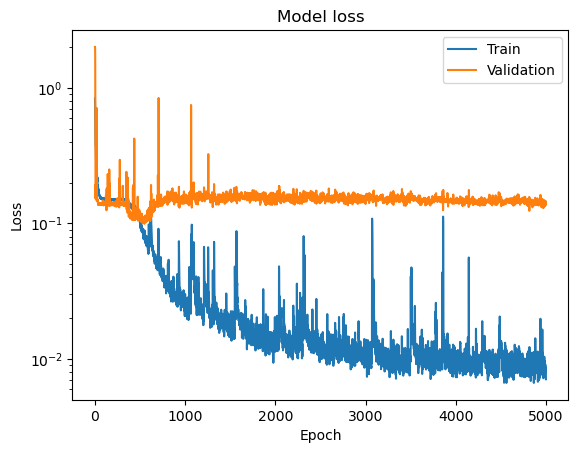

Final loss on validation set: 0.14303547143936157
Final mean absolute error on validation set: 0.2705163061618805


In [13]:
# plot the training and validation loss for each epoch and use a logarithmic scale
plt.semilogy(history.history['loss'])
plt.semilogy(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


# print the final loss and mean absolute error on the validation set
loss, mae = model.evaluate(X_val, y_val, verbose=0)
print("Final loss on validation set: {}".format(loss))
print("Final mean absolute error on validation set: {}".format(mae))

## revisions

### Version 1: 1st revision

- Final loss on validation set: 0.1474226713180542
- Final mean absolute error on validation set: 0.27334269881248474

### Version 1: 2nd revision

- Final loss on validation set: 0.10843917727470398
- Final mean absolute error on validation set: 0.2342437356710434

### Version 1: 3rd revision

- Final loss on validation set: 0.14303547143936157
- Final mean absolute error on validation set: 0.2705163061618805

1/1 [==============================] - 0s 13ms/step


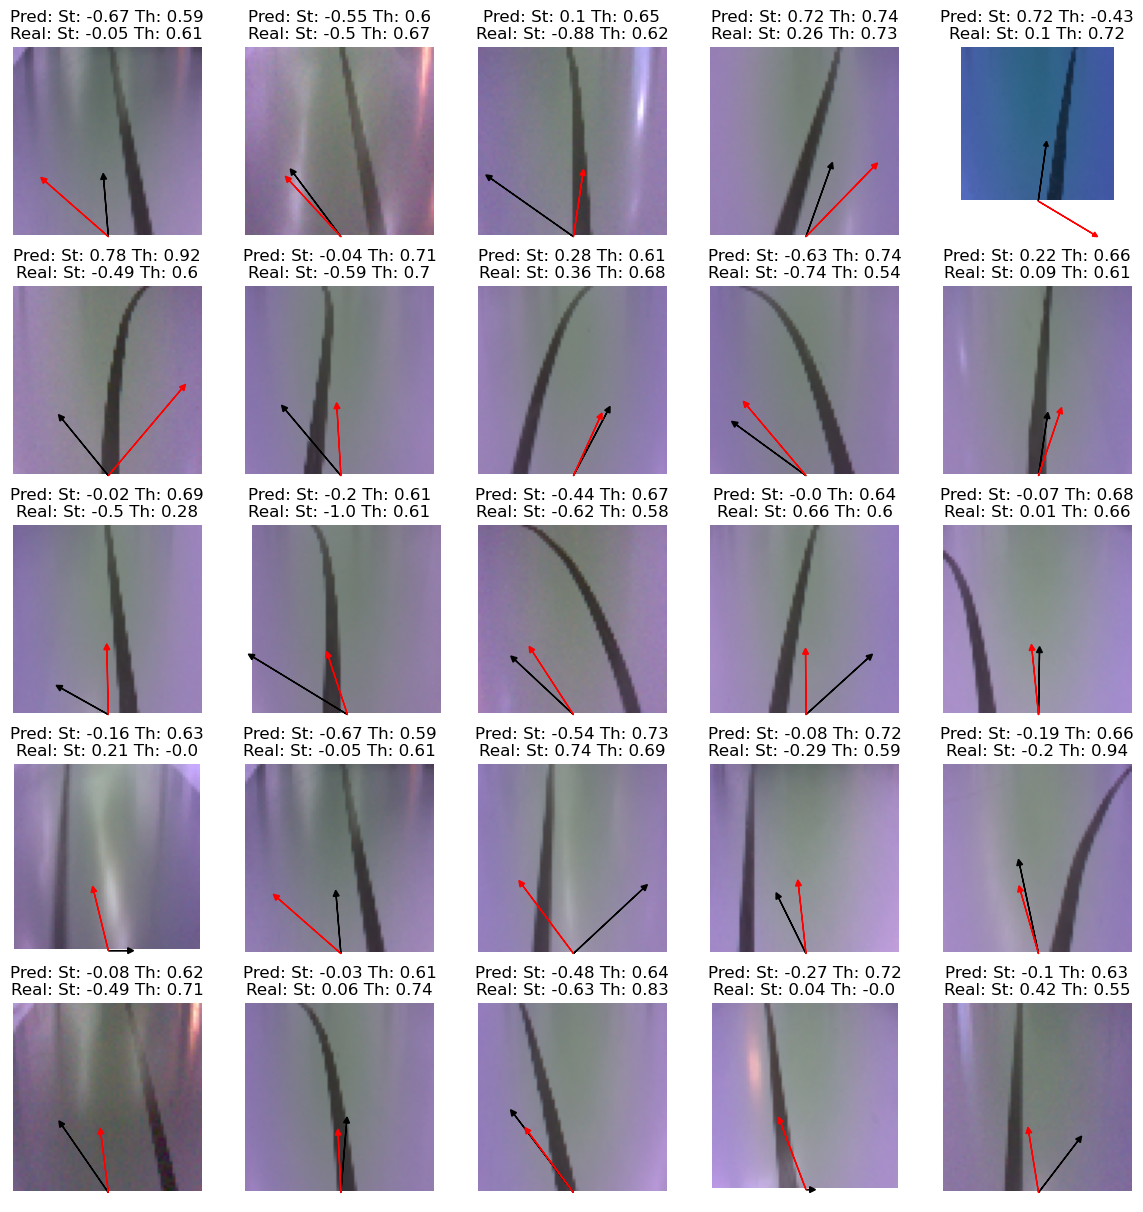

In [14]:
# the position of the arrow will be the middle bottom of the image, so the x position of the arrow will be the width of the image divided by 2
arrow_x = image_shape[1]/2
arrow_y = image_shape[0]

# now take a few images from the val set and predict the steering angle and throttle
# plot the image and the predicted steering angle and throttle and the real steering angle and throttle
fig, axs = plt.subplots(5, 5, figsize=(15, 15))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
for i in range(25):
    index = random.randint(0, X_val.shape[0])
    axs[i].imshow(X_val[index], cmap='gray')
    # predict the steering angle and throttle for the image (array of size 12288)
    st = model.predict(X_val[index].reshape(1, image_shape[0], image_shape[1], image_shape[2]))[0][0]
    th = model.predict(X_val[index].reshape(1, image_shape[0], image_shape[1], image_shape[2]))[0][1]
    axs[i].set_title("Pred: St: " + str(round(st, 2)) + " Th: " + str(round(th, 2)) + "\nReal: St: " + str(y_val[index][0]) + " Th: " + str(y_val[index][1]))
    axs[i].axis('off')
    # plot the image, the predicted steering angle and throttle and the real steering angle and throttle
    # also draw a arrow with the predicted steering angle and throttle
    # the arrow will be baced on the middle bottom of the image and will point up for throttle and left or right for steering angle
    # the length of the arrow will be the throttle and the angle of the arrow will be the steering angle
    # the length of the arrow will be between 0 and 1
    # the angle of the arrow will be between -1 and 1
    axs[i].arrow(arrow_x, arrow_y, y_val[index][0]*32, -y_val[index][1]*32, head_width=2, head_length=2, fc='k', ec='k')
    axs[i].arrow(arrow_x, arrow_y, st*32, -th*32, head_width=2, head_length=2, fc='r', ec='r')
    


## saving the model

Convert your model (in the variable `model`) and save the `.tflite` file

In [15]:
output_filename = 'mini_proj_model_v01_02.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

converter.target_spec.supported_types = [tf.float16]
tflite_fp16_model = converter.convert()

# This will save your model with the a file name tflite_model_fp16_file.tflite. You can uplaod this model file
# in your JetRacer a

with open(output_filename, 'wb') as f:
    f.write(tflite_fp16_model)


INFO:tensorflow:Assets written to: /var/folders/gd/_tzcwhnj41j_nysfjnpl80sc0000gn/T/tmpxanoyqd9/assets


INFO:tensorflow:Assets written to: /var/folders/gd/_tzcwhnj41j_nysfjnpl80sc0000gn/T/tmpxanoyqd9/assets
2022-12-18 05:55:20.656600: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-12-18 05:55:20.656617: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-12-18 05:55:20.657477: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/gd/_tzcwhnj41j_nysfjnpl80sc0000gn/T/tmpxanoyqd9
2022-12-18 05:55:20.661610: I tensorflow/cc/saved_model/reader.cc:81] Reading meta graph with tags { serve }
2022-12-18 05:55:20.661632: I tensorflow/cc/saved_model/reader.cc:122] Reading SavedModel debug info (if present) from: /var/folders/gd/_tzcwhnj41j_nysfjnpl80sc0000gn/T/tmpxanoyqd9
2022-12-18 05:55:20.674038: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2022-12-18 05:55:20.676585: I tensorflow/cc/saved_model/load